In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
#################### misc ####################
import os
from collections import defaultdict
#################### sklearn START ####################
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report
from sklearn.experimental import enable_iterative_imputer # is needed since data_processing_utils.py imports IterativeImputer
#################### sklearn END ####################
#################### imblearn START ####################
from imblearn.over_sampling import SVMSMOTE, SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
#################### imblearn END ####################
import tensorflow as tf
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from utils.data_processing_utils import save_df, plot_splits_distribution
from utils.model_utils import get_preprocessed_datasets , save_sklearn_model, load_sklearn_model, plot_confusion_matrix, load_and_concat_all_data
# plot_confusion_matrix, plot_roc_curve, plot_learning_curve, plot_feature_importance, plot_residuals, plot_predictions, plot_calibration_curve, plot_precision_recall_curve, plot_learning_curve,

## CONSTANTS:

In [2]:
YEAR_13: str = "2013"
YEAR_14: str = "2014"
YEAR_15: str = "2015"
YEAR_16: str = "2016"
YEAR_17: str = "2017"
YEAR_18: str = "2018"
YEAR_19: str = "2019"
YEAR_21: str = "2021"
YEAR_22: str = "2022"
YEAR_23: str = "2023"
YEARS: list[str] = [YEAR_13, YEAR_14, YEAR_15, YEAR_16, YEAR_17, YEAR_18, YEAR_19, YEAR_21, YEAR_22, YEAR_23]
SPLITS_KEYS: list[str] = ["k_5", "k_10", "k_15", "k_20", "k_half", "k_25", "k_30", "k_35", "k_40", "k_finish"]
SPLITS_NAMES: list[str] = ["5K", "10K", "15K", "20K", "Half", "25K", "30K", "35K", "40K", "Finish"]
SPLITS_ORDER: list[str] = ['k_5_time', 'k_5_pace', 'k_5_speed', 'k_10_time', 'k_10_pace', 'k_10_speed',
                           'k_15_time', 'k_15_pace', 'k_15_speed', 'k_20_time', 'k_20_pace', 'k_20_speed',
                           'k_half_time', 'k_half_pace', 'k_half_speed', 'k_25_time', 'k_25_pace', 'k_25_speed', 
                           'k_30_time', 'k_30_pace', 'k_30_speed', 'k_35_time', 'k_35_pace', 'k_35_speed',
                           'k_40_time', 'k_40_pace', 'k_40_speed', 'k_finish_time', 'k_finish_pace', 'k_finish_speed']

In [3]:
RAW_DATA_PATH = "Marathons_Data/Raw"
CLN_DATA_PATH = "Marathons_Data/Clean"
IMP_DATA_PATH = "Marathons_Data/Impute"
OTHER_DATA_PATH = "Marathons_Data/Other"
EXTENDED_DATA_PATH = "Marathons_Data/Extended"
#################### Marathons START ####################
# London
LDN: str = "London"
LDN_RAW_PATH: str = f"{RAW_DATA_PATH}/{LDN}"
LDN_CLN_PATH: str = f"{CLN_DATA_PATH}/{LDN}"
LDN_IMP_PATH: str = f"{IMP_DATA_PATH}/{LDN}"
LDN_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{LDN}"
# Hamburg
HAM: str = "Hamburg"
HAM_RAW_PATH: str = f"{RAW_DATA_PATH}/{HAM}"
HAM_CLN_PATH: str = f"{CLN_DATA_PATH}/{HAM}"
HAM_IMP_PATH: str = f"{IMP_DATA_PATH}/{HAM}"
HAM_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{HAM}"
# Houston
HOU: str = "Houston"
HOU_RAW_PATH: str = f"{RAW_DATA_PATH}/{HOU}"
HOU_CLN_PATH: str = f"{CLN_DATA_PATH}/{HOU}"
HOU_IMP_PATH: str = f"{IMP_DATA_PATH}/{HOU}"
HOU_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{HOU}"
# Stockholm
STO: str = "Stockholm"
STO_RAW_PATH: str = f"{RAW_DATA_PATH}/{STO}"
STO_CLN_PATH: str = f"{CLN_DATA_PATH}/{STO}"
STO_IMP_PATH: str = f"{IMP_DATA_PATH}/{STO}"
STO_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{STO}"
# Boston
BOS: str = "Boston"
BOS_RAW_PATH: str = f"{RAW_DATA_PATH}/{BOS}"
BOS_CLN_PATH: str = f"{CLN_DATA_PATH}/{BOS}"
BOS_IMP_PATH: str = f"{IMP_DATA_PATH}/{BOS}"
BOS_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{BOS}"
# Chicago
CHI: str = "Chicago"
CHI_RAW_PATH: str = f"{RAW_DATA_PATH}/{CHI}"
CHI_CLN_PATH: str = f"{CLN_DATA_PATH}/{CHI}"
CHI_IMP_PATH: str = f"{IMP_DATA_PATH}/{CHI}"
CHI_EXT_PATH: str = f"{EXTENDED_DATA_PATH}/{CHI}"
#################### Marathons END ####################
#################### Weather START ####################
WEATHER_DATA_PATH = f"{OTHER_DATA_PATH}/weather_marathon_data.csv"
WEATHER_COLS = ["daily_min", "daily_max", "medium_temp", "avg_humidity", "avg_barometer", "avg_windspeed"]
#################### Weather END ####################
#################### Model Save Paths START ####################
MODEL_SAVE_NORMAL = "Models/Normal/"
MODEL_SAVE_OVER = "Models/Oversampled/"
MODEL_SAVE_HYBRID = "Models/Hybrid/"
#################### Model Save Paths END ####################

In [4]:
DTYPE_DICT: defaultdict = defaultdict(np.float64, age_cat="category", gender="category", race_state="category", last_split="category", runner_type="category")
COLUMNS_ORDER = ['last_split', 'runner_type', 'age_cat', 'gender', 'race_state', 'daily_min', 
                'daily_max', 'medium_temp', 'avg_humidity', 'avg_barometer','avg_windspeed', 
                'k_5_time', 'k_5_pace', 'k_5_speed', 'k_10_time', 'k_10_pace', 'k_10_speed', 
                'k_15_time','k_15_pace', 'k_15_speed', 'k_20_time', 'k_20_pace', 'k_20_speed', 
                'k_half_time', 'k_half_pace', 'k_half_speed', 'k_25_time', 'k_25_pace', 'k_25_speed', 
                'k_30_time', 'k_30_pace', 'k_30_speed', 'k_35_time', 'k_35_pace', 'k_35_speed', 
                'k_40_time', 'k_40_pace', 'k_40_speed','k_finish_time', 'k_finish_pace', 'k_finish_speed']
CLASS_NAMES = ["Finished", "Started"]

## Feature Engineering (Only run if the Extended folder and its datasets do not exist):

In [35]:
def add_weather(df: pd.DataFrame, weather_df: pd.DataFrame, weather_cols: list[str], marathon_name: str, year: str) -> pd.DataFrame:
    """
    ### Add the weather data to the DataFrame.
    ----
    ### Arguments:
    + df: The DataFrame. 
    + weather_df: The weather DataFrame.
    + weather_cols: The weather columns.
    + marathon_name: The name of the marathon.
    + year: The year of the marathon.
    ----
    ### Returns:
    + df: The DataFrame with the weather data.
    """
    weather_np_arr = weather_df.loc[(weather_df["Marathon"] == marathon_name) & (weather_df["Year"] == int(year)), "Daily Min (C)":].to_numpy()[0]
    for i, col in enumerate(weather_cols):
        df[col] = weather_np_arr[i]
    return df


def get_runner_type(time: int) -> str:
    """
    ### Get the runner category, based on their finish time.
    ----
    ### Arguments:
    + time: The time of the runner.
    ----
    ### Returns:
    + The runner category.
    """
    ##########
    # elite <= 2:29:00 (8940 seconds)
    # 2:29:01 (8941 seconds) <= sub-elite <= 2:59:00 (10740)
    # 2:59:01 (10741 seconds) <= recreational-fast <= 4:14:00 (15240)
    # 4:14:01 (15241) <= recreational-slow <= 5:29:00 (19740)
    # occasional >= 5:29:01 (19741) 
    ##########
    if time <= 8940:
        return "elite"
    elif 8941 <= time <= 10740:
        return "sub-elite"
    elif 10741 <= time <= 15240:
        return "recreational-fast"
    elif 15241 <= time <= 19740:
        return "recreational-slow"
    else:
        return "occasional"
        
def add_runner_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    ### Add the runner category to the DataFrame.
    ----
    ### Arguments:
    + df: The DataFrame.
    ----
    ### Returns:
    + df: The DataFrame with the runner category.
    """
    df["runner_type"] = df["k_finish_time"].apply(get_runner_type)
    return df

def add_extra_features(df: pd.DataFrame, marathon_name: str, year: str, weather_df: pd.DataFrame, weather_cols: list[str]) -> pd.DataFrame|None:
    """
    ### Add the weather data and runner category to the DataFrame.
    ----
    ### Arguments:
    + df: The DataFrame.
    + marathon_name: The name of the marathon.
    + years: The years of the marathon.
    + weather_df: The weather DataFrame.
    + weather_cols: The weather columns.
    ----
    ### Returns:
    + df: The DataFrame with the weather data and runner category, if `parent_save_path` is None.
    + None, if `parent_save_path` is not None.
    """
    # Add the weather data.
    df = add_weather(df, weather_df, weather_cols, marathon_name, year)
    # Add runner category.
    df = add_runner_category(df)
    return df

def load_and_save_df_with_extra_features(marathon_name: str, years: list[str], data_parent_path:str, parent_save_path: str, weather_df: pd.DataFrame, weather_cols: list[str]) -> None:
    """
    ### Load the DataFrames, add the weather data and runner category, then save it.
    ----
    ### Arguments:
    + marathon_name: The name of the marathon.
    + years: The years of the marathon.
    + data_parent_path: The path to load the DataFrame.
    + parent_save_path: The path to save the DataFrame.
    + weather_df: The weather DataFrame.
    + weather_cols: The weather columns.
    ----
    ### Returns:
    + None
    """
    for year in years:
        # Define Load Paths.
        iter_path = f"{data_parent_path}/{marathon_name}{year}/{marathon_name}{year}_iter_impute.csv"
        knn_path = f"{data_parent_path}/{marathon_name}{year}/{marathon_name}{year}_knn_impute.csv"
        # Define Save Paths.
        iter_save_path = f"{parent_save_path}/{marathon_name}{year}/{marathon_name}{year}_iter_ext.csv"
        knn_save_path = f"{parent_save_path}/{marathon_name}{year}/{marathon_name}{year}_knn_ext.csv"
        
        # Load the DataFrames.
        if os.path.isfile(iter_path) and os.path.isfile(knn_path):
            df_iter = pd.read_csv(iter_path, dtype=DTYPE_DICT)
            df_knn = pd.read_csv(knn_path, dtype=DTYPE_DICT)
        else:
            print(f"DataFrame not found at {iter_path} or {knn_path}.")
            continue
        
        # Add the weather data and runner category.
        df_iter = add_extra_features(df_iter, marathon_name, year, weather_df, weather_cols)
        df_knn = add_extra_features(df_knn, marathon_name, year, weather_df, weather_cols)
        
        # Save the DataFrames.
        if df_iter.isna().sum().sum() == 0 and df_knn.isna().sum().sum() == 0:
            save_df(df_iter, iter_save_path)
            print(f"DataFrame saved to {iter_save_path}.")
            save_df(df_knn, knn_save_path)
            print(f"DataFrame saved to {knn_save_path}.")
        else:
            print(f"DataFrame has {df_iter.isna().sum().sum()} NaNs.")
            print(f"DataFrame has {df_knn.isna().sum().sum()} NaNs.")

In [33]:
# Load the weather data.
weather_df = pd.read_csv(WEATHER_DATA_PATH)

### London:

In [36]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(LDN, YEARS, LDN_IMP_PATH, LDN_EXT_PATH, weather_df, WEATHER_COLS)

DataFrame not found at Marathons_Data/Impute/London/London2013/London2013_iter_impute.csv or Marathons_Data/Impute/London/London2013/London2013_knn_impute.csv.
DataFrame saved to Marathons_Data/Extended/London/London2014/London2014_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2014/London2014_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2015/London2015_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2015/London2015_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2016/London2016_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2016/London2016_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2017/London2017_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2017/London2017_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2018/London2018_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/London/London2018/London201

### Hamburg:

In [37]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(HAM, YEARS, HAM_IMP_PATH, HAM_EXT_PATH, weather_df, WEATHER_COLS)

DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2013/Hamburg2013_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2013/Hamburg2013_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2014/Hamburg2014_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2014/Hamburg2014_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2015/Hamburg2015_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2015/Hamburg2015_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2016/Hamburg2016_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2016/Hamburg2016_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2017/Hamburg2017_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2017/Hamburg2017_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Hamburg/Hamburg2018/Hamburg2018_iter_ext.csv.
DataFrame saved to Maratho

### Houston:

In [39]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(HOU, YEARS[5:7], HOU_IMP_PATH, HOU_EXT_PATH, weather_df, WEATHER_COLS)

DataFrame saved to Marathons_Data/Extended/Houston/Houston2018/Houston2018_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Houston/Houston2018/Houston2018_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Houston/Houston2019/Houston2019_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Houston/Houston2019/Houston2019_knn_ext.csv.


### Stockholm:

In [41]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(STO, YEARS[7:9], STO_IMP_PATH, STO_EXT_PATH, weather_df, WEATHER_COLS)

DataFrame saved to Marathons_Data/Extended/Stockholm/Stockholm2021/Stockholm2021_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Stockholm/Stockholm2021/Stockholm2021_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Stockholm/Stockholm2022/Stockholm2022_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Stockholm/Stockholm2022/Stockholm2022_knn_ext.csv.


### Boston:

In [57]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(BOS, YEARS, BOS_IMP_PATH, BOS_EXT_PATH, weather_df, WEATHER_COLS)

DataFrame not found at Marathons_Data/Impute/Boston/Boston2013/Boston2013_iter_impute.csv or Marathons_Data/Impute/Boston/Boston2013/Boston2013_knn_impute.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2014/Boston2014_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2014/Boston2014_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2015/Boston2015_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2015/Boston2015_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2016/Boston2016_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2016/Boston2016_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2017/Boston2017_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2017/Boston2017_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2018/Boston2018_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Boston/Boston2018/Boston201

### Chicago:

In [56]:
# Add the weather data and runner category to the DataFrames, or each marathon then save it.
load_and_save_df_with_extra_features(CHI, YEARS, CHI_IMP_PATH, CHI_EXT_PATH, weather_df, WEATHER_COLS)

DataFrame not found at Marathons_Data/Impute/Chicago/Chicago2013/Chicago2013_iter_impute.csv or Marathons_Data/Impute/Chicago/Chicago2013/Chicago2013_knn_impute.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2014/Chicago2014_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2014/Chicago2014_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2015/Chicago2015_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2015/Chicago2015_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2016/Chicago2016_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2016/Chicago2016_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2017/Chicago2017_iter_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2017/Chicago2017_knn_ext.csv.
DataFrame saved to Marathons_Data/Extended/Chicago/Chicago2018/Chicago2018_iter_ext.csv.
DataFrame saved to Marathons_Data/Ext

## Data Analysis and Visualisation:

In [5]:
# def load_and_concat_all_data(marathon_name: str, parent_path: str, years: list[str], dataset_name: str=None, dataset_type:str ="impute", dtype=None) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]|pd.DataFrame:
#     """
#     ### Load and concatenate all the DataFrames.
#     ----
#     ### Arguments:
#     + marathon_name: The name of the marathon.
#     + parent_path: The path to load the DataFrames.
#     + years: The years of the marathon.
#     + dataset_name: The name of the dataset to return.
#     + dtype: The data types of the DataFrame.
#     + dataset_type: The type of the dataset, either the imputed `impute` or the extended `ext`.
#     ----
#     ### Returns:
#     + data: The DataFrames, if `dataset_name` is None.
#     + The specified DataFrame, if `dataset_name` is not None.
#     """
#     # Check the dataset type.
#     assert dataset_type in ["impute", "ext"], "dataset_type must be either `impute` or `ext`."

#     data = [[], []]
#     for year in years:
#         knn_path = f"{parent_path}/{marathon_name}{year}/{marathon_name}{year}_knn_{dataset_type}.csv"
#         iter_path = f"{parent_path}/{marathon_name}{year}/{marathon_name}{year}_iter_{dataset_type}.csv"
#         if os.path.isfile(knn_path) and os.path.isfile(iter_path):
#             data[0].append(pd.read_csv(knn_path, dtype=dtype))
#             data[1].append(pd.read_csv(iter_path, dtype=dtype))
#         else:
#             print(f"DataFrame not found at {knn_path} or {iter_path}.")
#             continue
#     # Concatenate all data
#     data[0] = pd.concat(data[0], ignore_index=True)
#     data[1] = pd.concat(data[1], ignore_index=True)
#     if dataset_name:
#         match dataset_name:
#             case "knn":
#                 return data[0]
#             case "iter":
#                 return data[1]
#     return data

### London:

In [6]:
df_data = load_and_concat_all_data(LDN, LDN_EXT_PATH, YEARS[1:], "iter", dataset_type='ext', dtype=DTYPE_DICT)

In [13]:
# time_cols = [time for time in df_data.columns.to_list() if "_time" in time ]
# for i, time in enumerate(time_cols[:-1]):
#     plt.subplot(3, 3, i+1)
#     sns.scatterplot(x=df_data[time], y=df_data["k_finish_time"], hue=df_data["race_state"]);
# plt.tight_layout()

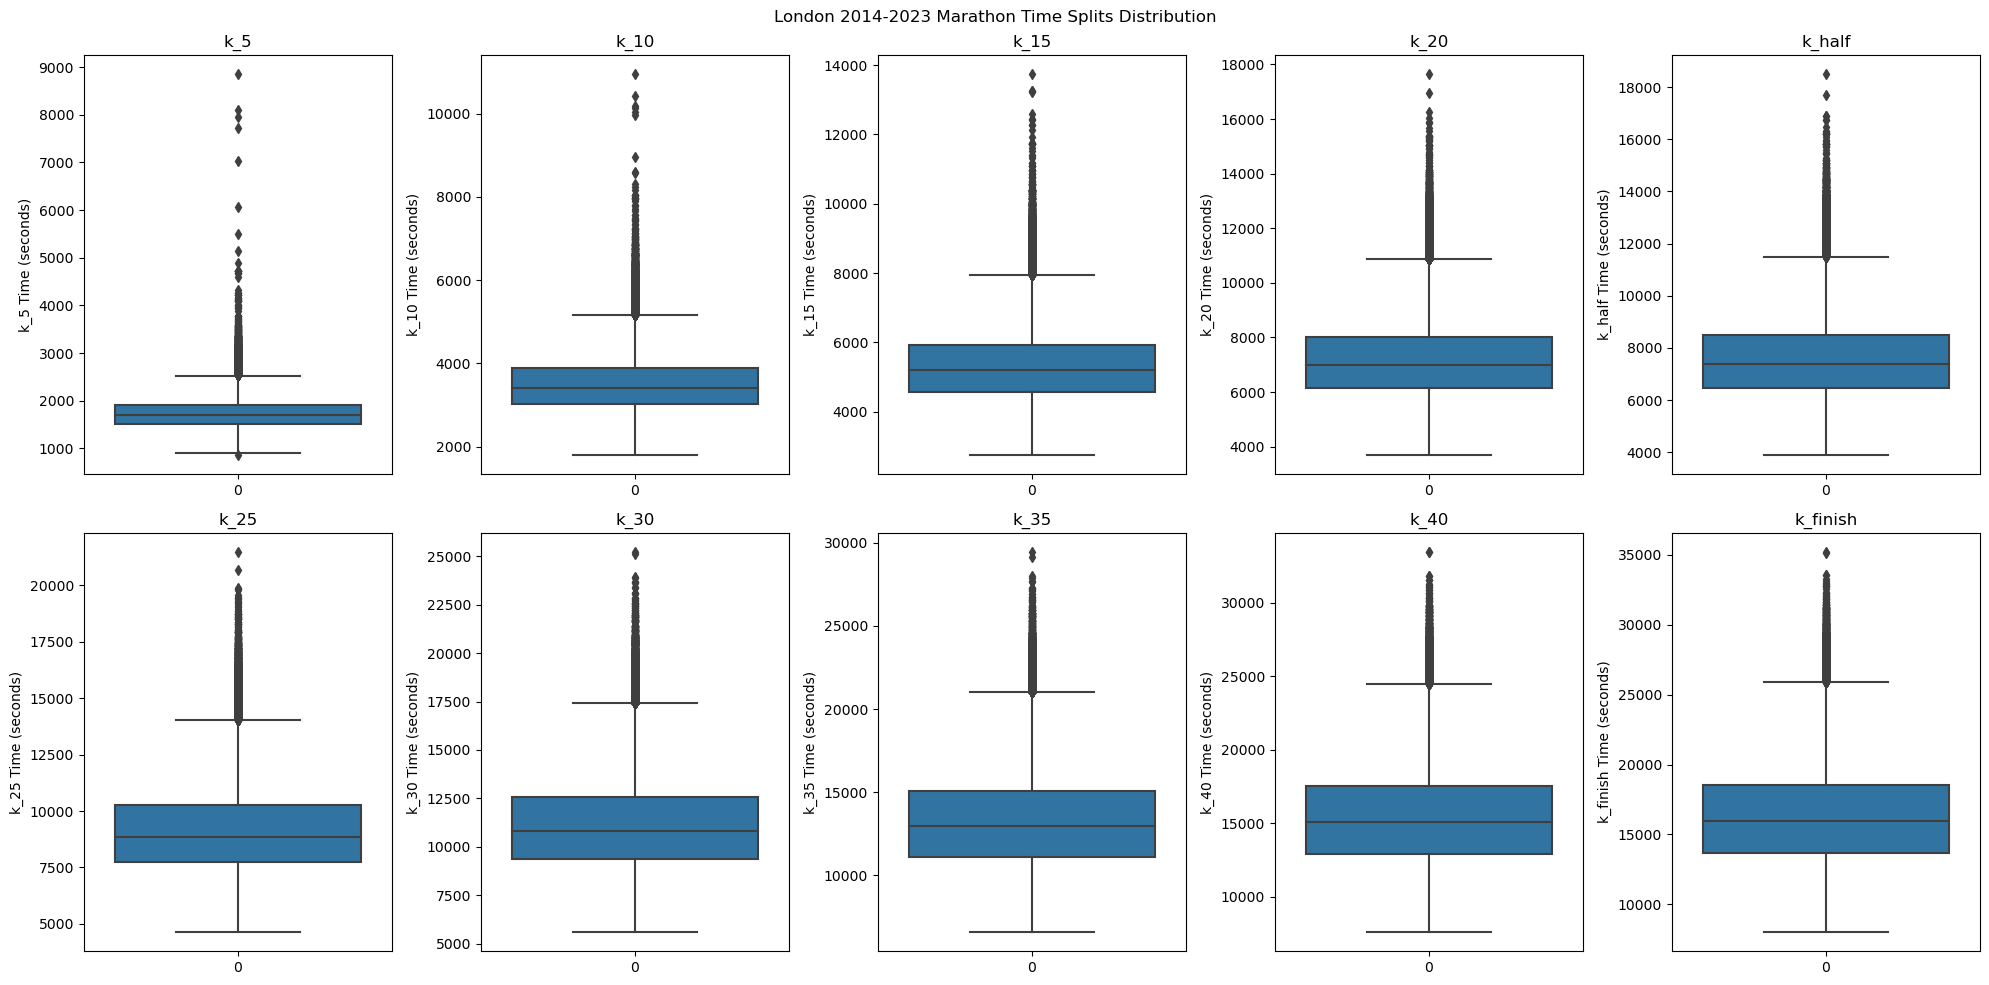

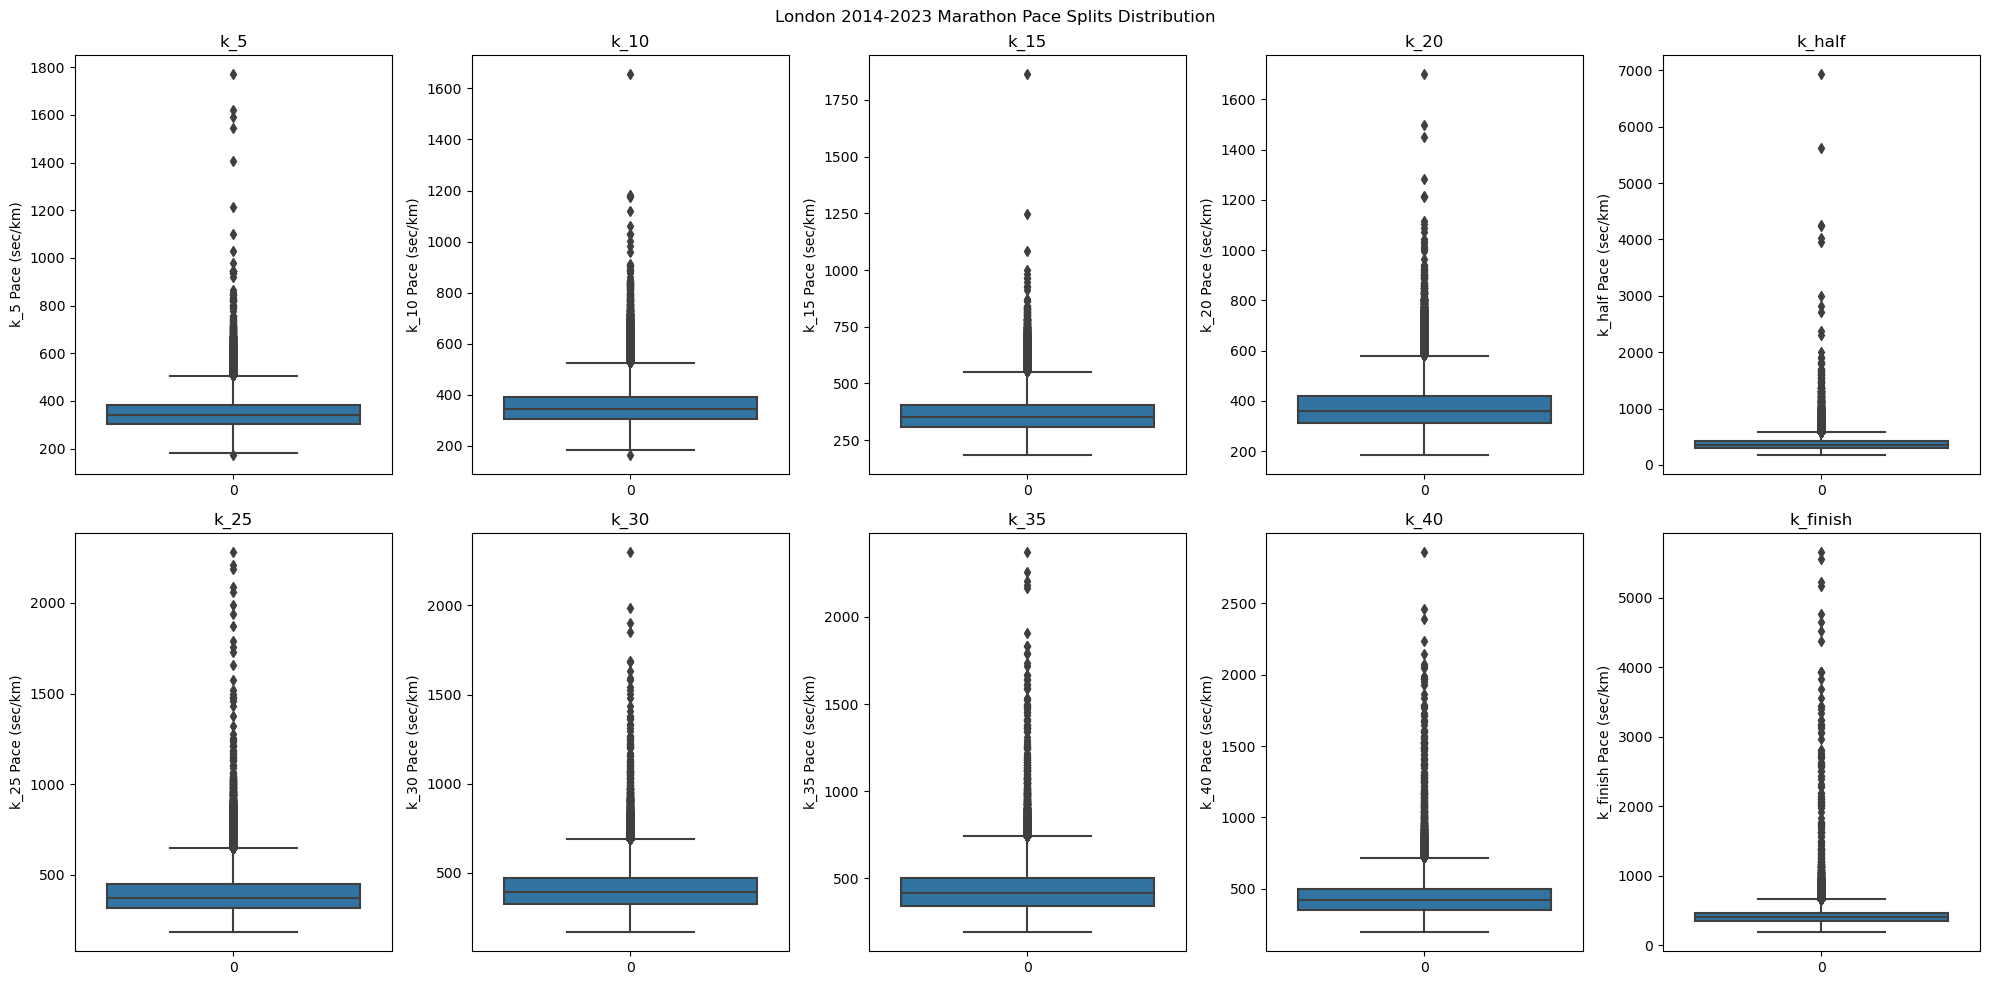

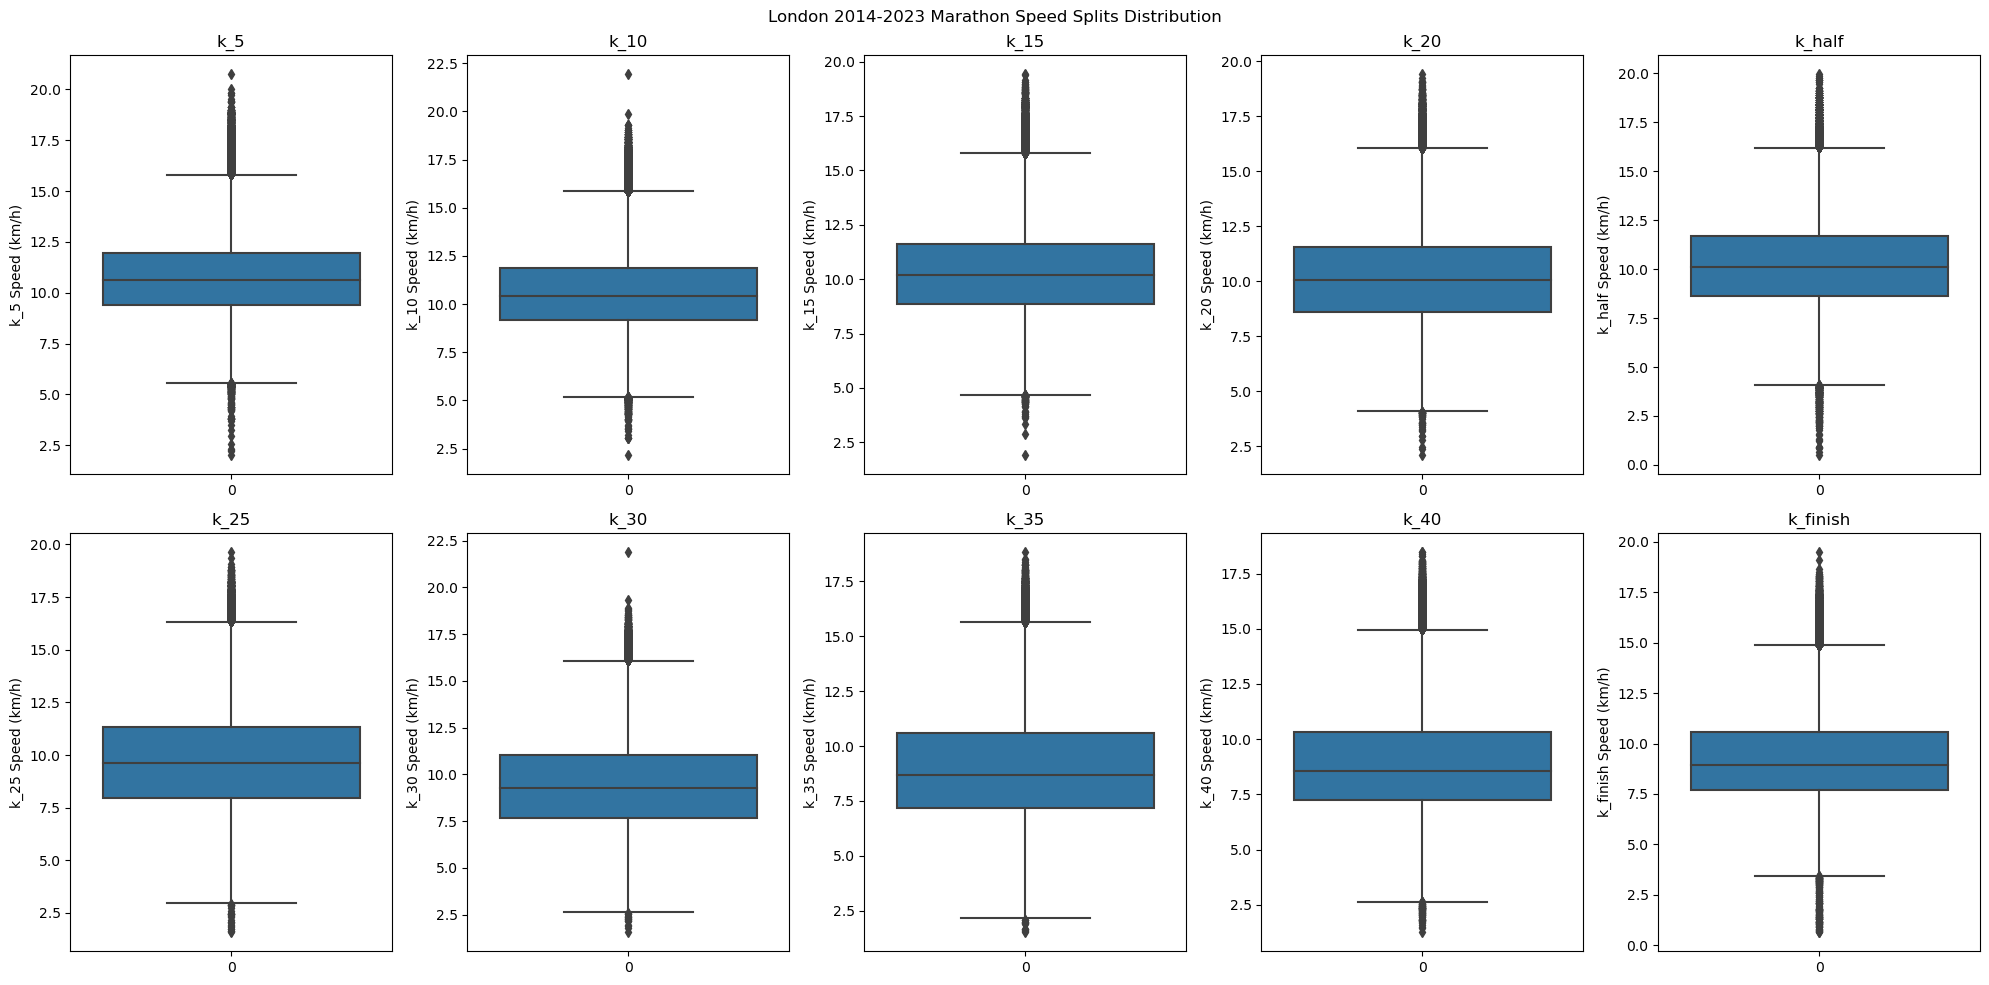

In [14]:
plot_splits_distribution(df_data, SPLITS_KEYS, "London", "2014-2023")

### Hamburg:

In [24]:
df = load_and_concat_all_data(HAM, HAM_EXT_PATH, YEARS, "iter", dataset_type='ext', dtype=DTYPE_DICT)

DataFrame not found at Marathons_Data/Extended/Hamburg/Hamburg2021/Hamburg2021_knn_ext.csv or Marathons_Data/Extended/Hamburg/Hamburg2021/Hamburg2021_iter_ext.csv.


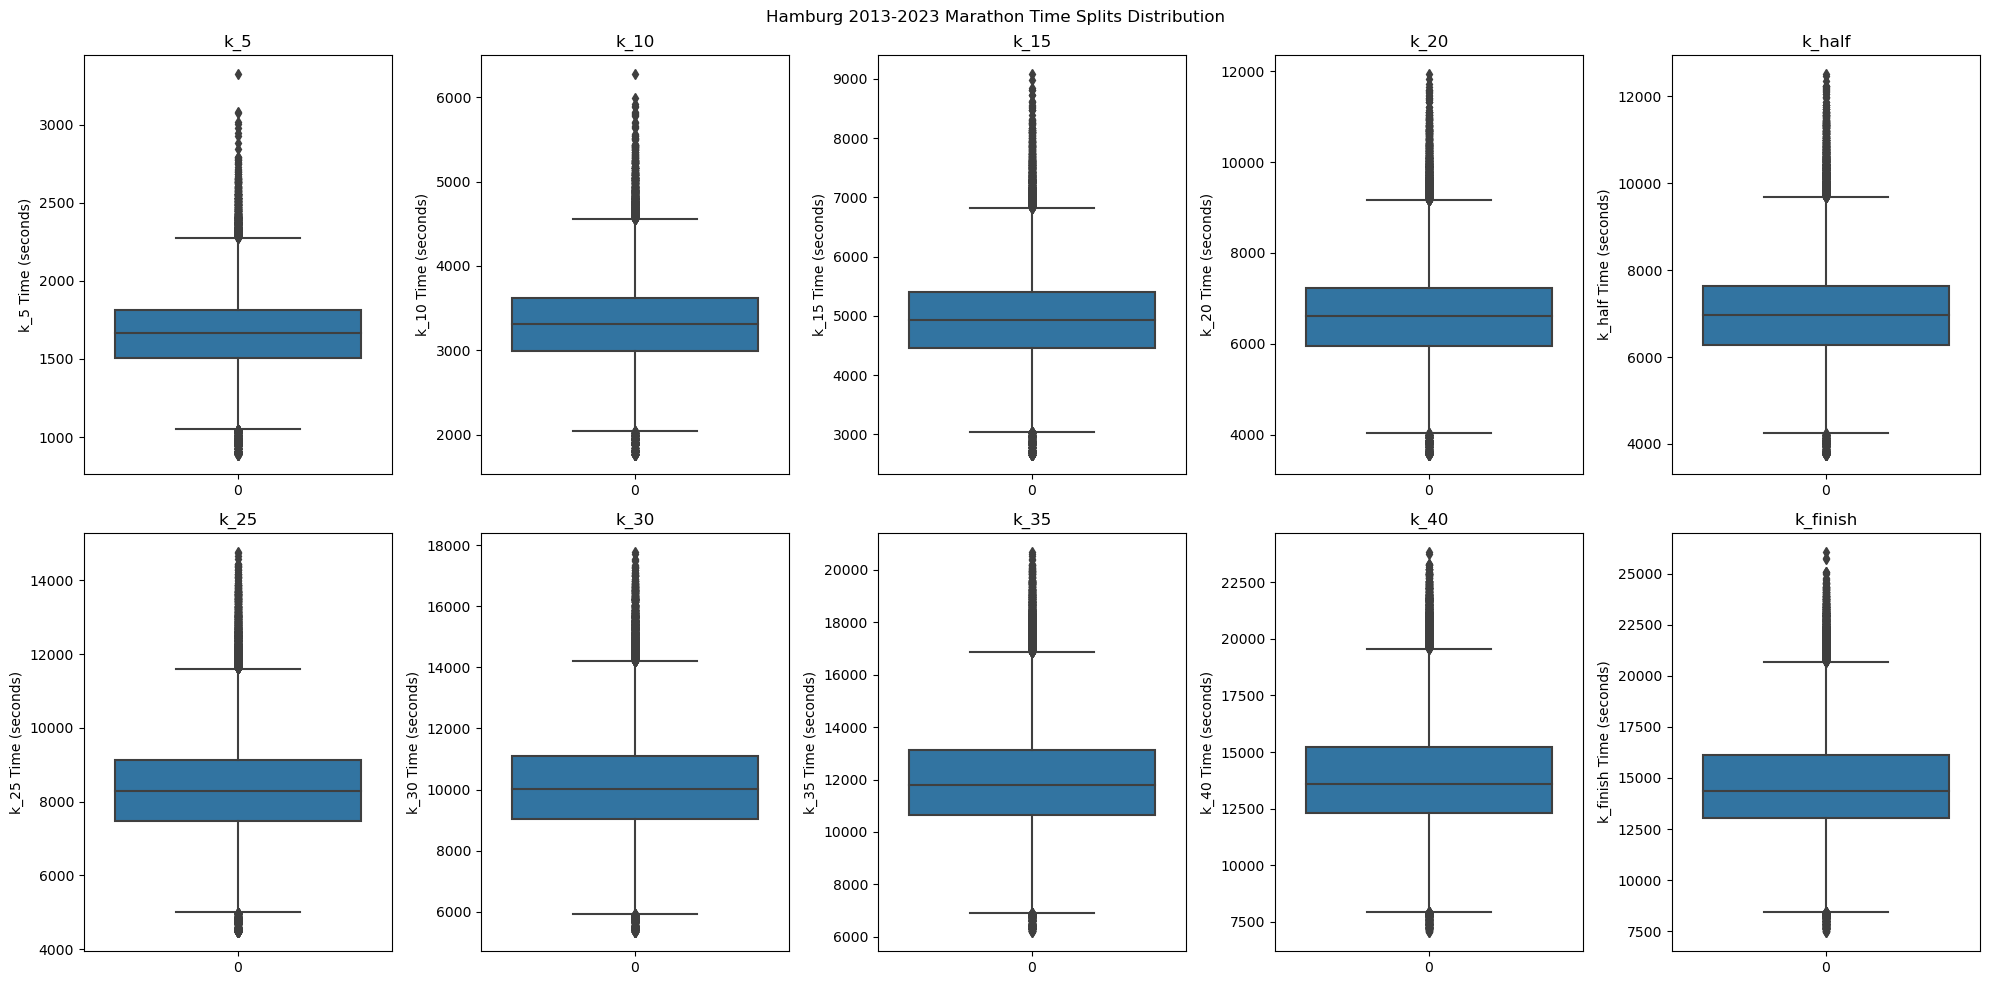

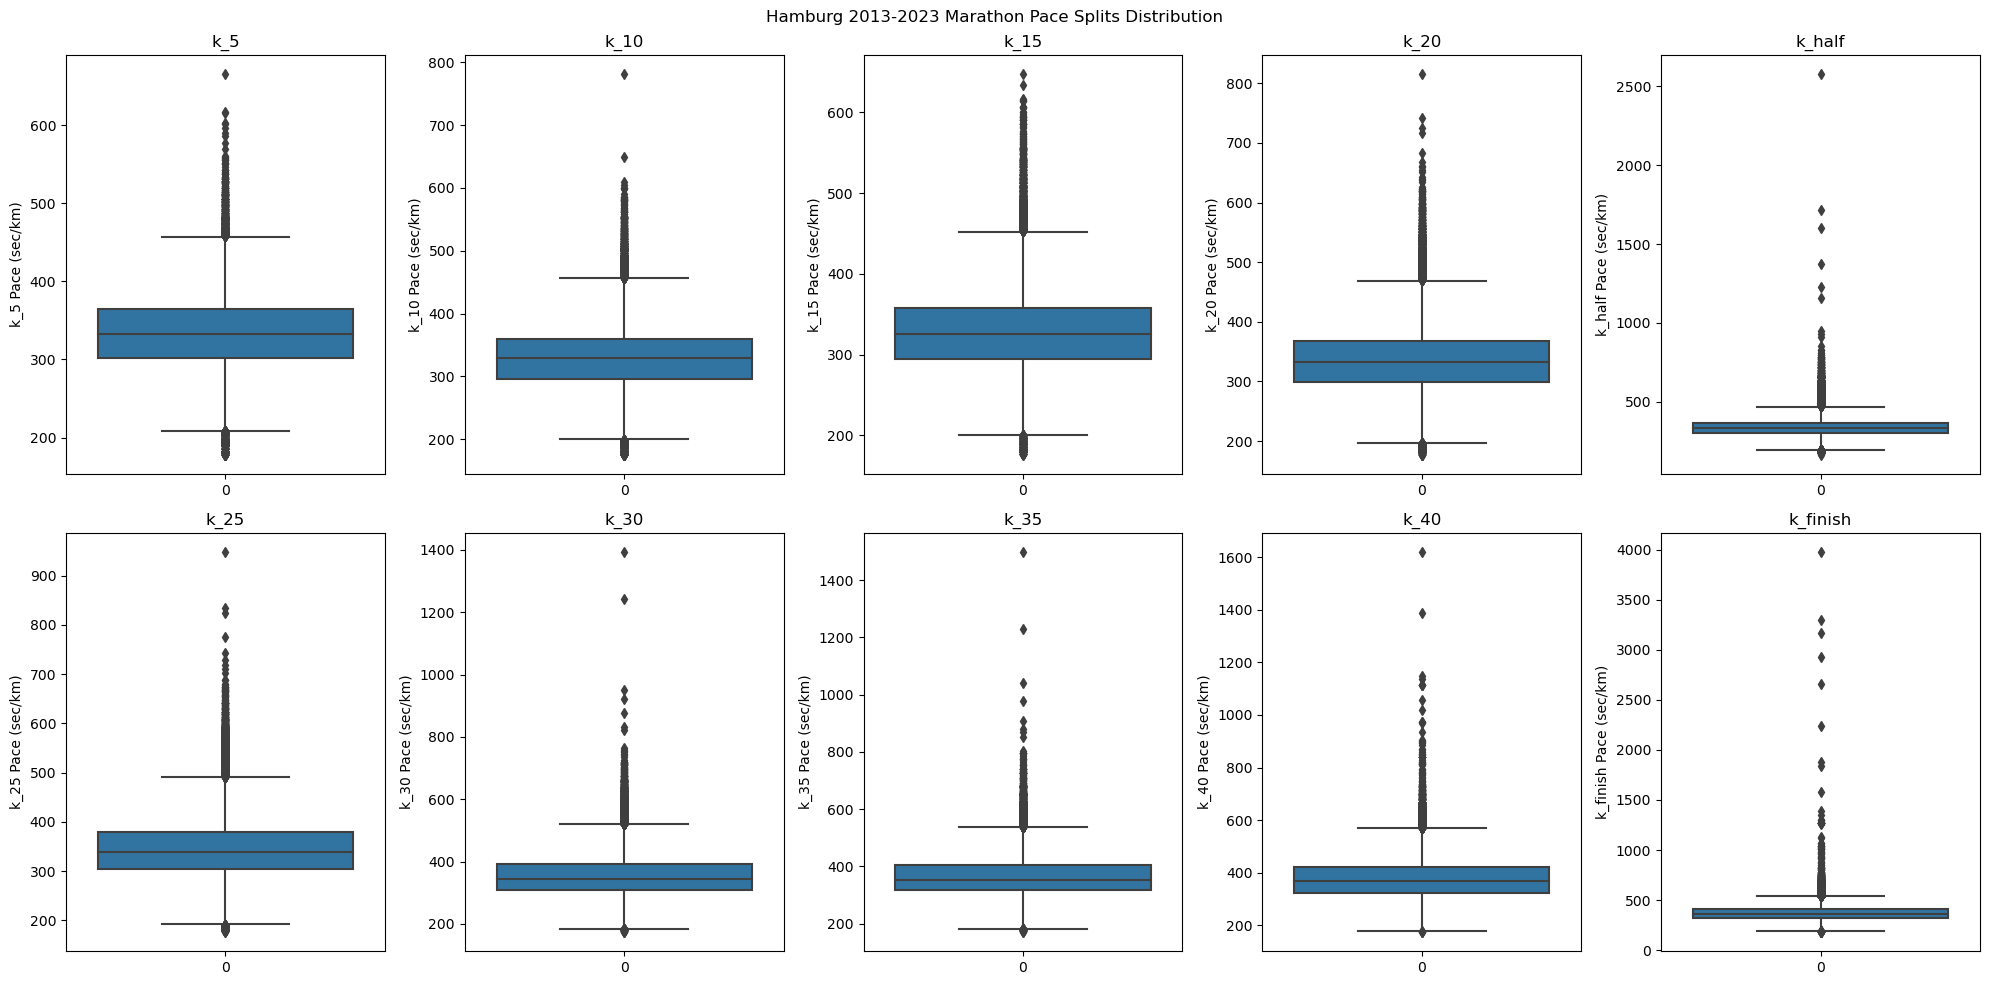

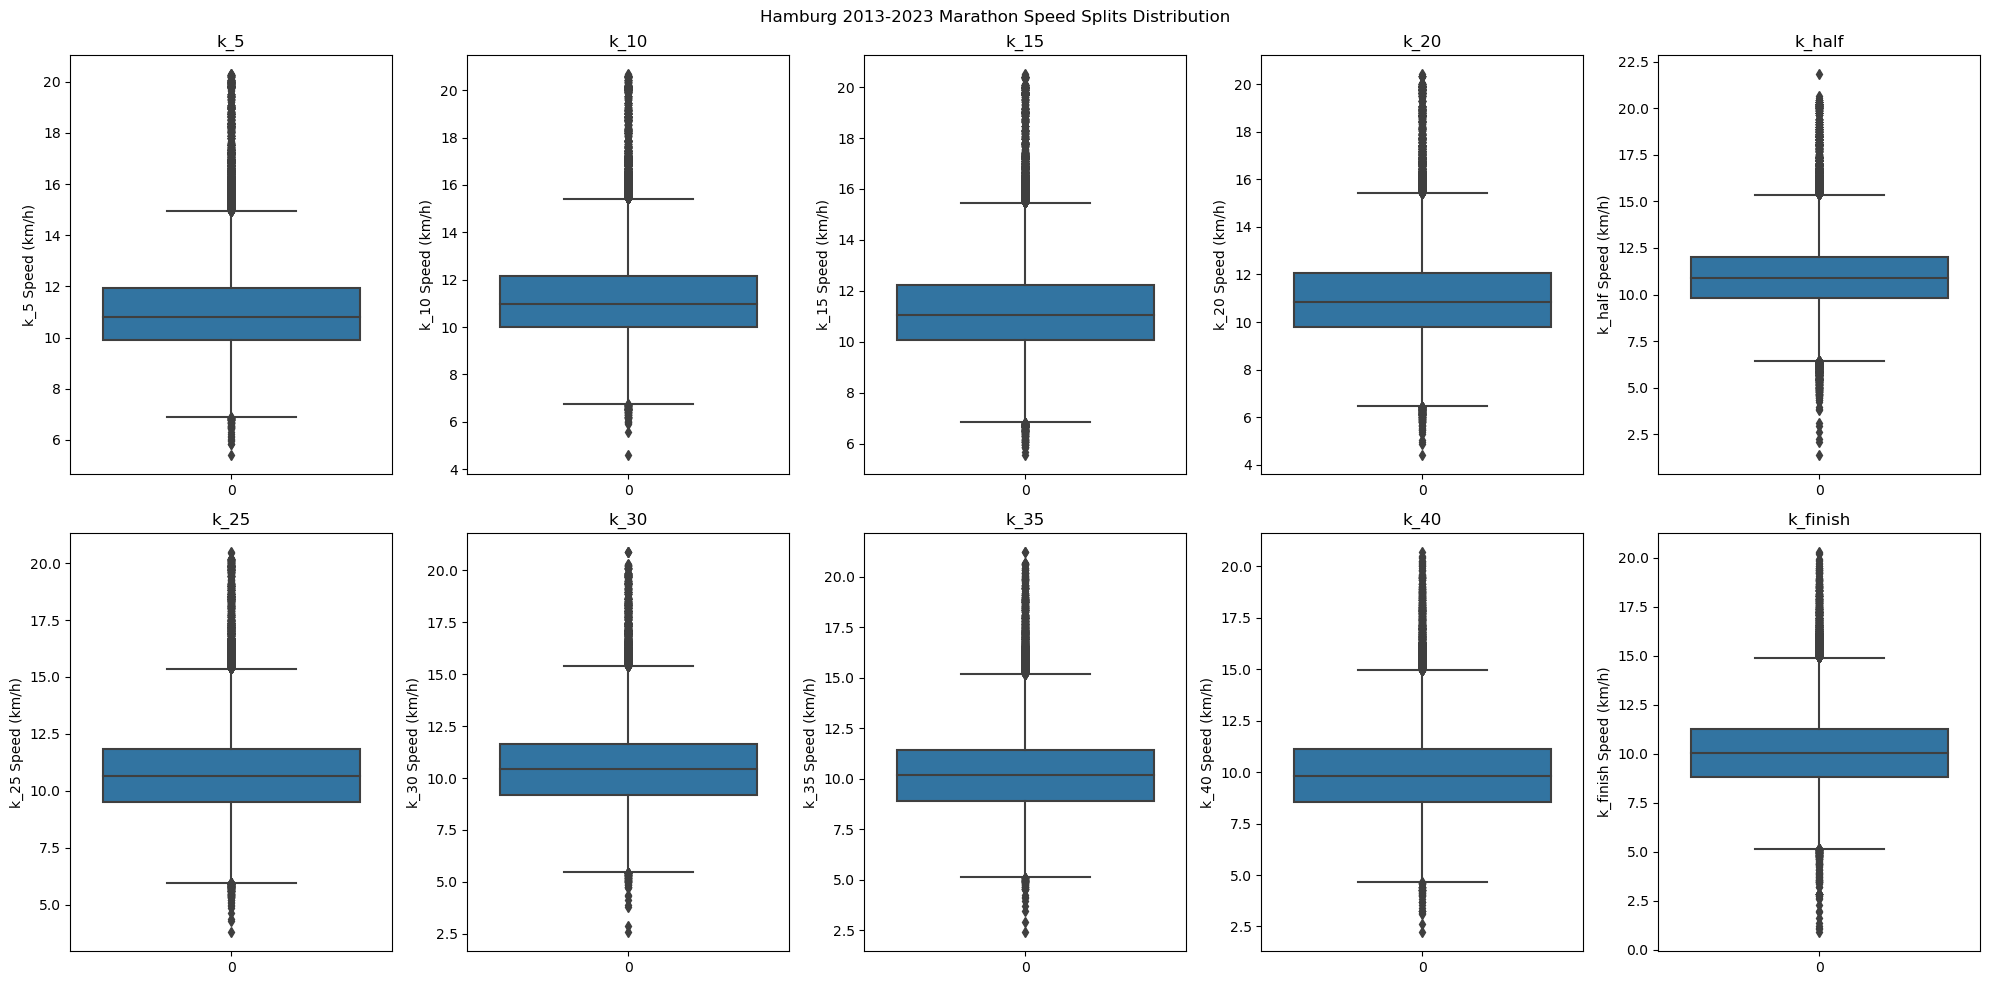

In [25]:
plot_splits_distribution(df, SPLITS_KEYS, "Hamburg", "2013-2023")

In [30]:
df.filter(regex="k_.*_speed").describe(percentiles=[.25, .5, .75, .9, .95, .99])

,k_5_speed,k_10_speed,k_15_speed,k_20_speed,k_half_speed,k_25_speed,k_30_speed,k_35_speed,k_40_speed,k_finish_speed
count,101475.000000,101475.000000,101475.000000,101475.000000,101475.000000,101475.000000,101475.000000,101475.00000,101475.000000,101475.000000
mean,11.057414,11.181556,11.242247,11.015456,10.962645,10.746565,10.491715,10.23679,9.916646,10.113422
std,1.674560,1.754992,1.753352,1.793981,1.838896,1.876306,1.954469,1.97303,1.955140,1.889349
min,5.420000,4.610000,5.560000,4.420000,1.400000,3.800000,2.580000,2.40000,2.220000,0.900000
25%,9.910000,10.000000,10.070000,9.810000,9.790000,9.500000,9.180000,8.89000,8.530000,8.820000
50%,10.820000,10.970000,11.040000,10.860000,10.870000,10.660000,10.450000,10.18000,9.830000,10.030000
75%,11.930000,12.170000,12.230000,12.050000,12.030000,11.850885,11.660000,11.41000,11.100000,11.260000
90%,13.240000,13.450000,13.490000,13.280000,13.240000,13.090000,12.930000,12.70000,12.400000,12.500000
95%,14.200000,14.340000,14.370000,14.230000,14.190000,14.090000,13.950000,13.68000,13.310000,13.370000
99%,16.192600,16.300000,16.330000,16.140000,16.050000,15.970000,15.790000,15.56000,15.180000,15.170000


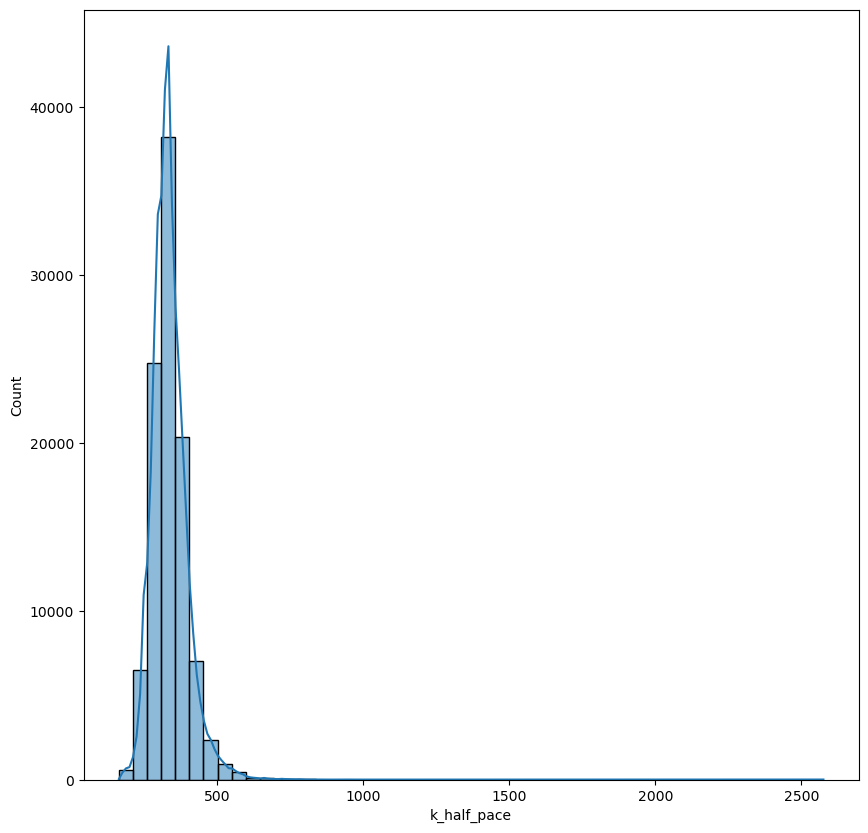

In [81]:
plt.figure(figsize=(10, 10))
# sns.histplot(df.filter(regex="k_.*_pace")["k_half_pace"], bins=50, kde=True, log_scale=True);
sns.histplot(df.filter(regex="k_.*_pace")["k_half_pace"], bins=50, kde=True);

In [77]:
df.filter(regex="k_.*_pace")["k_finish_pace"].skew()

4.182509059058174

In [78]:
np.log(df.filter(regex="k_.*_pace")["k_finish_pace"]).skew()

0.37220009758320016

# Datasets Pre-Processing:

In [5]:
### Dropout Prediction Datasets:
MARATHON_NAMES = [HAM, HOU, STO, BOS, CHI]
MARATHON_EXT_PATHS = [HAM_EXT_PATH, HOU_EXT_PATH, STO_EXT_PATH, BOS_EXT_PATH, CHI_EXT_PATH]

df_data = load_and_concat_all_data(LDN, LDN_EXT_PATH, YEARS, "iter", dataset_type='ext', dtype=DTYPE_DICT)
for marathon_name, ext_path in zip(MARATHON_NAMES, MARATHON_EXT_PATHS):
    tmp = load_and_concat_all_data(marathon_name, ext_path, YEARS, "iter", dataset_type='ext', dtype=DTYPE_DICT)
    df_data = pd.concat([df_data, tmp], ignore_index=True)

DataFrame not found at Marathons_Data/Extended/London/London2013/London2013_knn_ext.csv or Marathons_Data/Extended/London/London2013/London2013_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Hamburg/Hamburg2021/Hamburg2021_knn_ext.csv or Marathons_Data/Extended/Hamburg/Hamburg2021/Hamburg2021_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Houston/Houston2013/Houston2013_knn_ext.csv or Marathons_Data/Extended/Houston/Houston2013/Houston2013_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Houston/Houston2014/Houston2014_knn_ext.csv or Marathons_Data/Extended/Houston/Houston2014/Houston2014_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Houston/Houston2015/Houston2015_knn_ext.csv or Marathons_Data/Extended/Houston/Houston2015/Houston2015_iter_ext.csv.
DataFrame not found at Marathons_Data/Extended/Houston/Houston2016/Houston2016_knn_ext.csv or Marathons_Data/Extended/Houston/Houston2016/Houston2016_iter_ext.csv.
DataFrame not found at

### Dropout Prediction:

In [6]:
# Getting the datasets. takes around (20 seconds).
train, test, val, dataset_cols = get_preprocessed_datasets(df_data, COLUMNS_ORDER, SPLITS_ORDER, return_cols=True, last_split=10)
X_train, y_train = train
X_test, y_test = test
X_val, y_val = val

Transforming skewed features...

Transforming columns (oneHotEncoding and Scaling)...

("The columns to be used: ['daily_min', 'daily_max', 'medium_temp', "
 "'avg_humidity', 'avg_barometer', 'avg_windspeed', 'age_cat_18-39', "
 "'age_cat_40-44', 'age_cat_45-49', 'age_cat_50-54', 'age_cat_55-59', "
 "'age_cat_60-64', 'age_cat_65-69', 'age_cat_70+', 'gender_W', "
 "'runner_type_elite', 'runner_type_occasional', "
 "'runner_type_recreational-fast', 'runner_type_recreational-slow', "
 "'runner_type_sub-elite', 'k_5_time', 'k_5_pace', 'k_10_time', 'k_10_pace', "
 "'k_15_time', 'k_15_pace', 'k_20_time', 'k_20_pace', 'k_half_time', "
 "'k_half_pace', 'k_25_time', 'k_25_pace', 'k_30_time', 'k_30_pace', "
 "'k_35_time', 'k_35_pace', 'k_40_time', 'k_40_pace', 'k_finish_time', "
 "'k_finish_pace']")


In [8]:
print("Normal Data Shape:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Normal Data Shape:
X_train shape: (617705, 40), y_train shape: (617705,)
X_test shape: (205902, 40), y_test shape: (205902,)
X_val shape: (205902, 40), y_val shape: (205902,)


In [10]:
# Define the stratified k-fold cross-validator for marathon dropout prediction.
K_FOLD_NUM = 5
s_kfold = StratifiedKFold(n_splits=K_FOLD_NUM, shuffle=True, random_state=17)

### Performance Prediction:

In [6]:
# Define the k-fold cross-validator for marathon performance prediction.
K_FOLD_NUM = 5
kfold = KFold(n_splits=K_FOLD_NUM, shuffle=True, random_state=17)

# Models:

## Marathon Dropout Prediction:

### Extended Dataset:

#### KNN:

In [10]:
knn_cls = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='distance')

In [12]:
cv_score = cross_val_score(knn_cls, X_train, y_train, cv=s_kfold, scoring='average_precision', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

Cross Validation Score k=5: 0.338 (0.011)


In [13]:
knn_cls.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [15]:
y_pred = knn_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      1.00      0.99    201900
     Started       0.70      0.26      0.38      4002

    accuracy                           0.98    205902
   macro avg       0.84      0.63      0.69    205902
weighted avg       0.98      0.98      0.98    205902



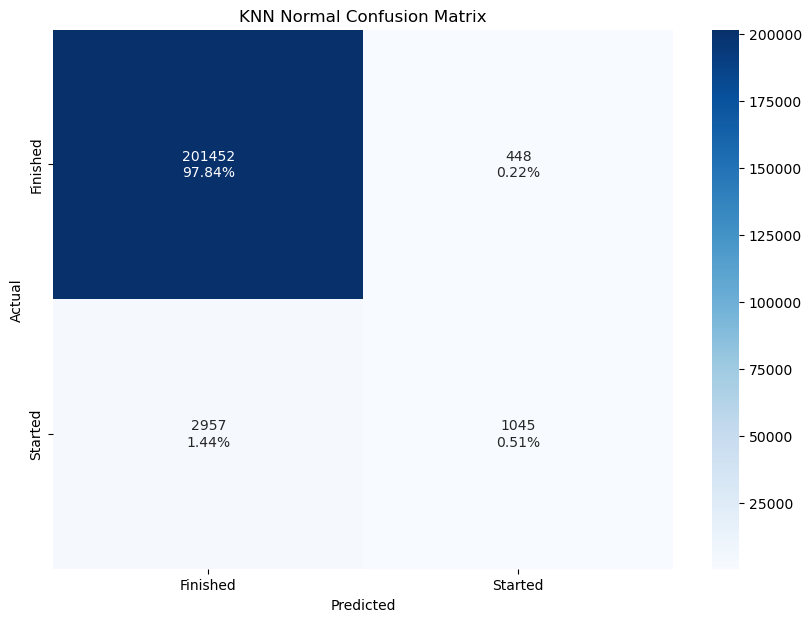

In [16]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="KNN Normal Confusion Matrix")

In [17]:
save_sklearn_model(knn_cls, "KNN_normal", MODEL_SAVE_NORMAL)

Model saved to Models/Normal/KNN_normal.joblib


In [18]:
del knn_cls

#### Random Forest:

In [19]:
rfr_cls = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=2, min_samples_split=4, criterion='gini', random_state=17, n_jobs=-1)

In [20]:
cv_score = cross_val_score(rfr_cls, X_train, y_train, cv=s_kfold, scoring='average_precision', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

Cross Validation Score k=5: 0.507 (0.011)


In [21]:
rfr_cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=17)

<Axes: >

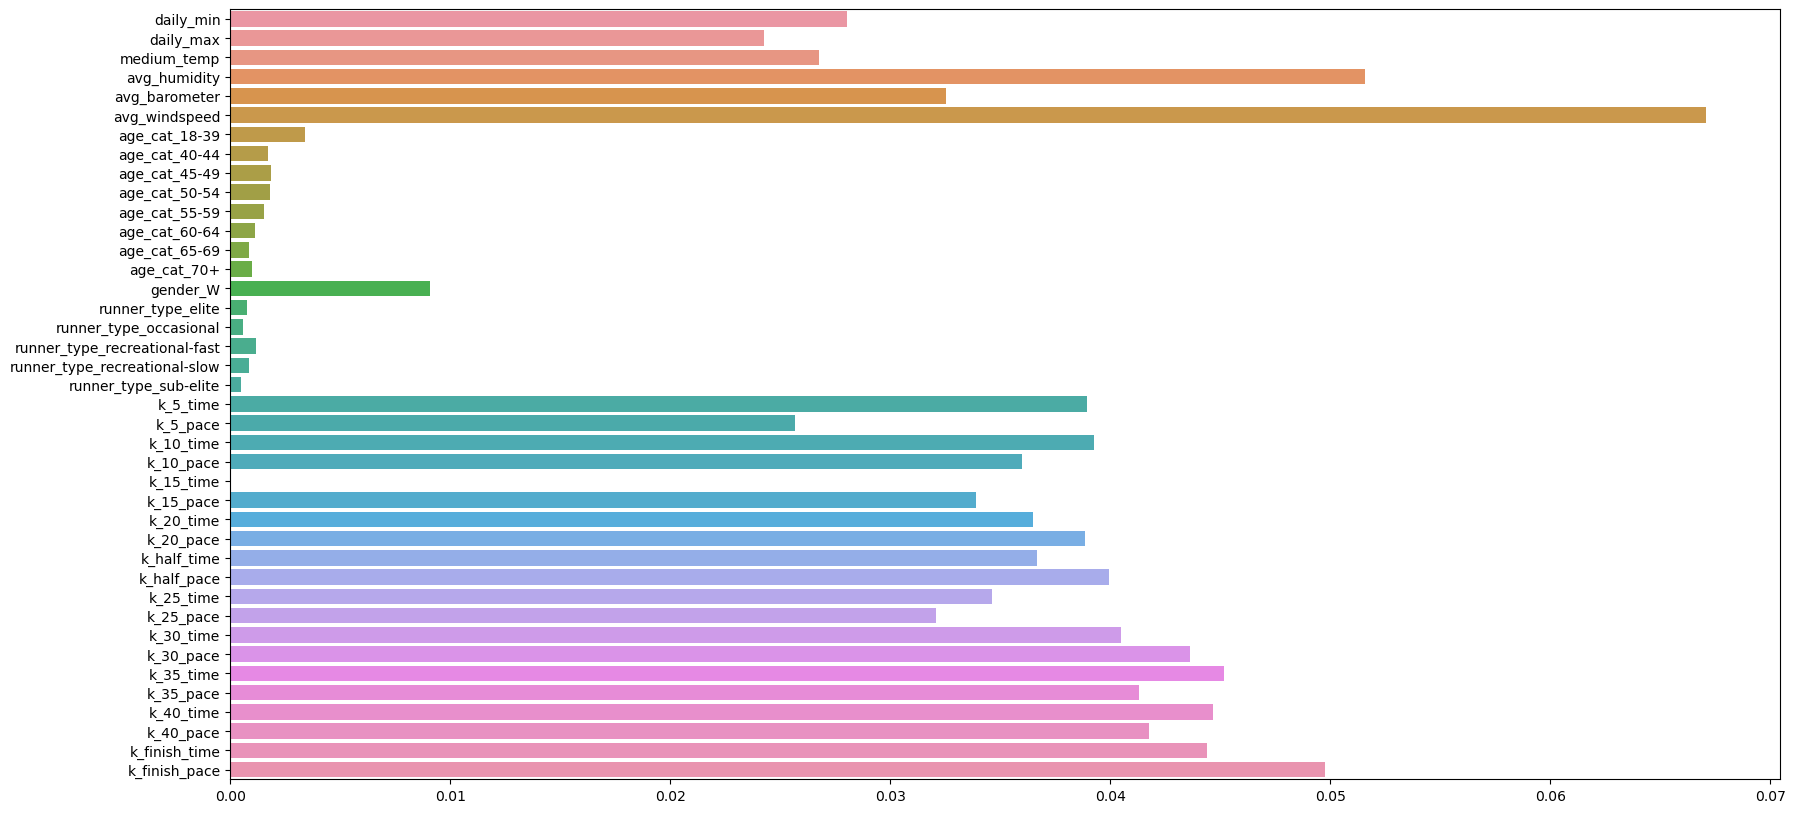

In [22]:
plt.figure(figsize=(20, 10))
sns.barplot(x=rfr_cls.feature_importances_, y=dataset_cols)

In [24]:
y_pred = rfr_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      1.00      0.99    201900
     Started       0.86      0.28      0.42      4002

    accuracy                           0.99    205902
   macro avg       0.93      0.64      0.71    205902
weighted avg       0.98      0.99      0.98    205902



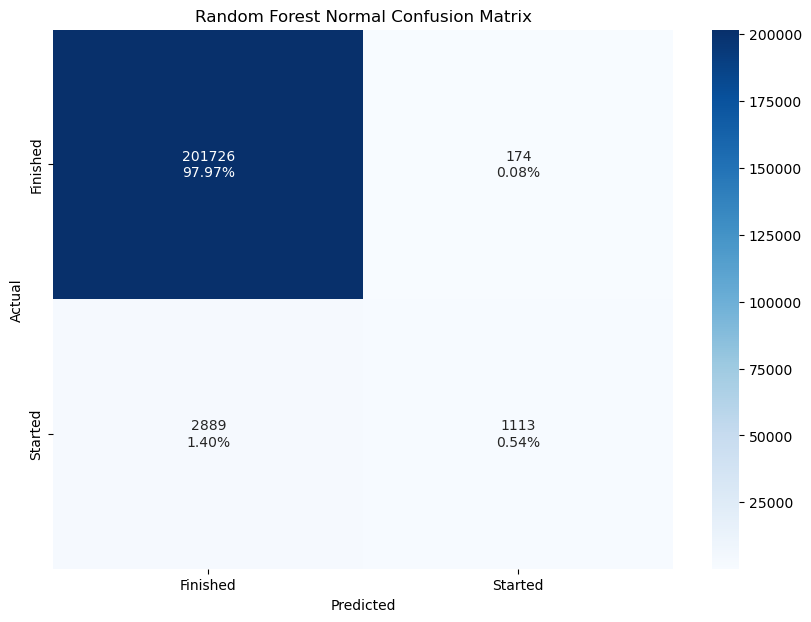

In [25]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="Random Forest Normal Confusion Matrix")

In [26]:
save_sklearn_model(rfr_cls, "RandomForest_normal", MODEL_SAVE_NORMAL)

Model saved to Models/Normal/RandomForest_normal.joblib


In [27]:
del rfr_cls

#### Balanced Random Forest:

In [28]:
brf_cls = BalancedRandomForestClassifier(n_estimators=500, max_depth=20, sampling_strategy="all", replacement=True, 
                                         min_samples_leaf=2, min_samples_split=4, random_state=17, n_jobs=-1)

In [29]:
cv_score = cross_val_score(brf_cls, X_test, y_test, cv=s_kfold, scoring='average_precision', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

Cross Validation Score k=5: 0.388 (0.011)


In [30]:
brf_cls.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=20, min_samples_leaf=2,
                               min_samples_split=4, n_estimators=500, n_jobs=-1,
                               random_state=17, replacement=True,
                               sampling_strategy='all')

<Axes: >

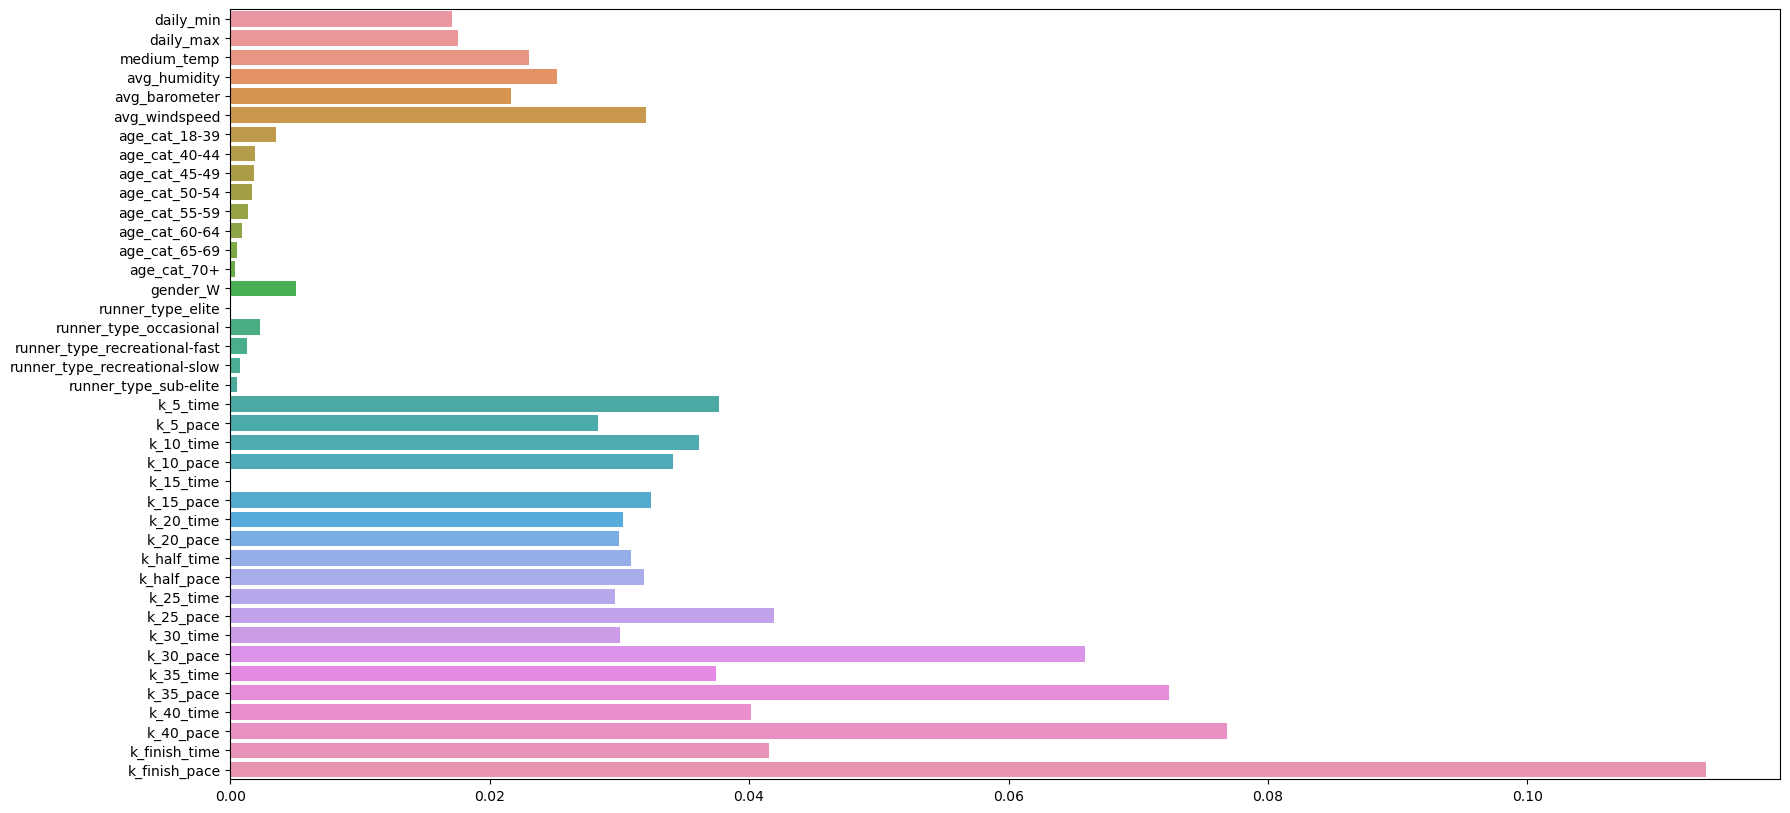

In [31]:
plt.figure(figsize=(20, 10))
sns.barplot(x=brf_cls.feature_importances_, y=dataset_cols)

In [33]:
y_pred = brf_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       1.00      0.88      0.94    201900
     Started       0.12      0.82      0.21      4002

    accuracy                           0.88    205902
   macro avg       0.56      0.85      0.58    205902
weighted avg       0.98      0.88      0.92    205902



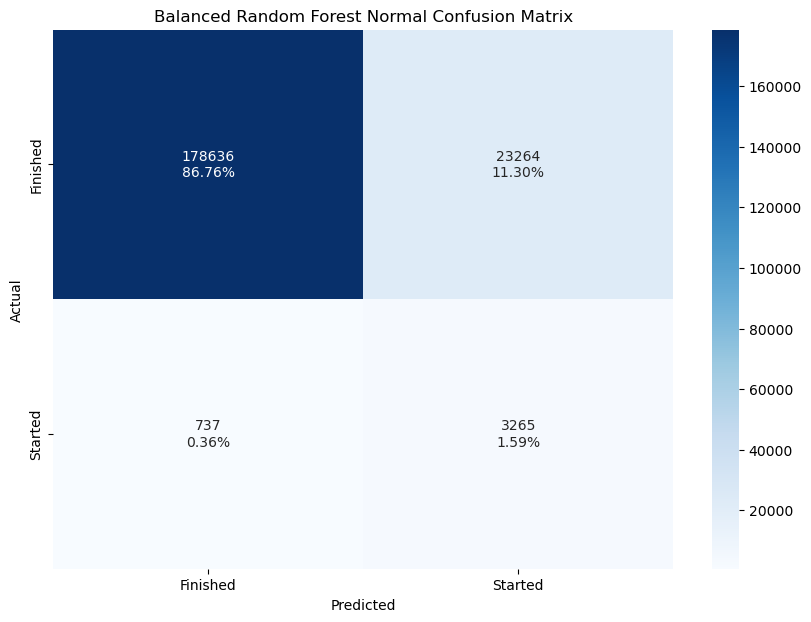

In [34]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="Balanced Random Forest Normal Confusion Matrix")

In [35]:
save_sklearn_model(brf_cls, "BalancedRandomForest_normal", MODEL_SAVE_NORMAL)

Model saved to Models/Normal/BalancedRandomForest_normal.joblib


In [36]:
del brf_cls

#### XGBoost:

In [46]:
xgb_cls = XGBClassifier(n_estimators=200, max_depth=20, eval_metric="aucpr", max_delta_step=2, reg_lambda=3, 
                        reg_alpha=1, learning_rate=0.8, gamma=0.1, random_state=17, n_jobs=-1)


In [47]:
cv_score = cross_val_score(xgb_cls, X_train, y_train, cv=s_kfold, scoring='average_precision', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

Cross Validation Score k=5: 0.615 (0.008)


In [48]:
eval_set = [(X_val, y_val)]
xgb_cls.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-aucpr:0.38410
[1]	validation_0-aucpr:0.45162
[2]	validation_0-aucpr:0.48599
[3]	validation_0-aucpr:0.51030
[4]	validation_0-aucpr:0.52012
[5]	validation_0-aucpr:0.53610
[6]	validation_0-aucpr:0.54970
[7]	validation_0-aucpr:0.55564
[8]	validation_0-aucpr:0.55880
[9]	validation_0-aucpr:0.56645
[10]	validation_0-aucpr:0.57094
[11]	validation_0-aucpr:0.57309
[12]	validation_0-aucpr:0.57320
[13]	validation_0-aucpr:0.57644
[14]	validation_0-aucpr:0.57749
[15]	validation_0-aucpr:0.57726
[16]	validation_0-aucpr:0.57931
[17]	validation_0-aucpr:0.58071
[18]	validation_0-aucpr:0.58062
[19]	validation_0-aucpr:0.58123
[20]	validation_0-aucpr:0.58159
[21]	validation_0-aucpr:0.58314
[22]	validation_0-aucpr:0.58602
[23]	validation_0-aucpr:0.58768
[24]	validation_0-aucpr:0.58808
[25]	validation_0-aucpr:0.58854
[26]	validation_0-aucpr:0.58986
[27]	validation_0-aucpr:0.59012
[28]	validation_0-aucpr:0.59006
[29]	validation_0-aucpr:0.59118
[30]	validation_0-aucpr:0.59204
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=2,
              max_depth=20, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=17, ...)

<Axes: >

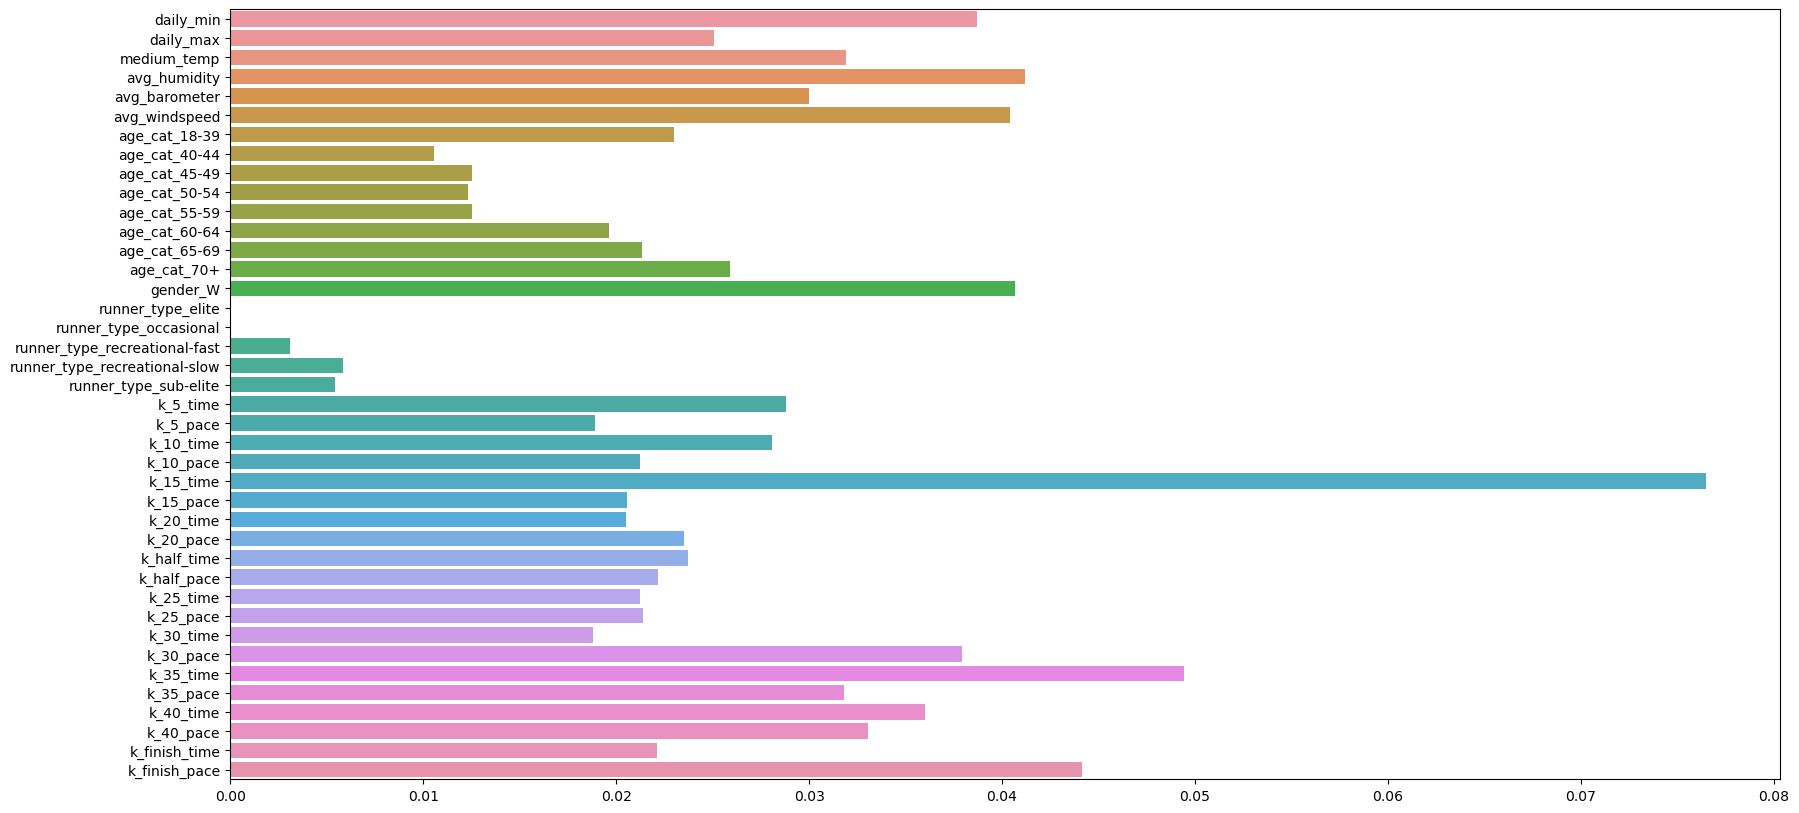

In [49]:
plt.figure(figsize=(20, 10))
sns.barplot(x=xgb_cls.feature_importances_, y=dataset_cols)

In [52]:
y_pred = xgb_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      1.00      0.99    201900
     Started       0.81      0.44      0.57      4002

    accuracy                           0.99    205902
   macro avg       0.90      0.72      0.78    205902
weighted avg       0.99      0.99      0.99    205902



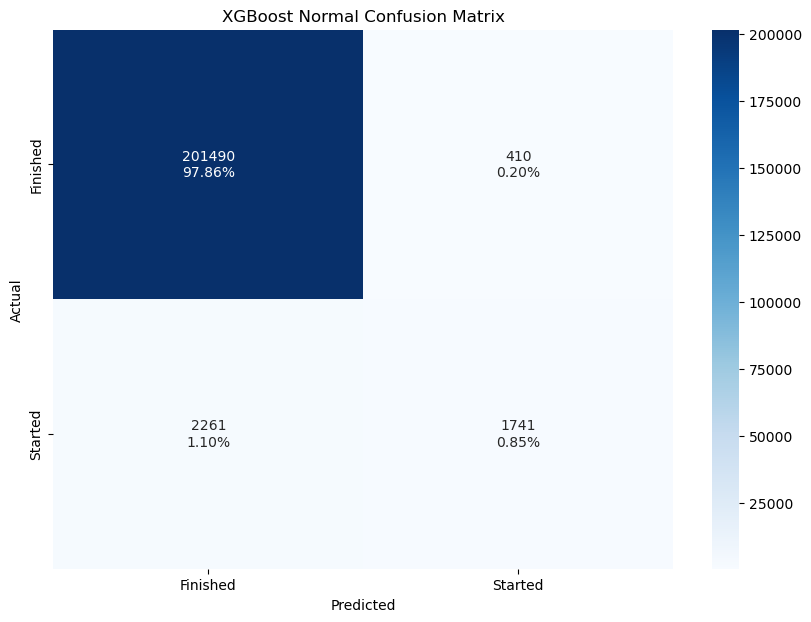

In [53]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="XGBoost Normal Confusion Matrix")

In [54]:
xgb_cls.save_model(f"{MODEL_SAVE_NORMAL}XGBoost_normal.json")

In [55]:
del xgb_cls

#### Neural Network:

In [51]:
METRICS = [
    #   tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    #   tf.keras.metrics.MeanSquaredError(name='Brier score'),
    #   tf.keras.metrics.TruePositives(name='tp'),
    #   tf.keras.metrics.FalsePositives(name='fp'),
    #   tf.keras.metrics.TrueNegatives(name='tn'),
    #   tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy', metrics=METRICS)

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                2624      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6849 (26.75 KB)
Trainable params: 6849 (26.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
302/302 [==============================] - 8s 26ms/step - loss: 0.1223 - accuracy: 0.9732 - precision: 0.0204 - recall: 0.0080 - auc: 0.6339 - prc: 0.0285 - val_loss: 0.0823 - val_accuracy: 0.9806 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8043 - val_prc: 0.1170
Epoch 2/100
302/302 [==============================] - 7s 23ms/step - loss: 0.0822 - accuracy: 0.9809 - precision: 0.7616 - recall: 0.0218 - auc: 0.7961 - prc: 0.1595 - val_loss: 0.0730 - val_accuracy: 0.9813 - val_precision: 0.9140 - val_recall: 0.0425 - val_auc: 0.8421 - val_prc: 0.2874
Epoch 3/100
302/302 [==============================] - 7s 22ms/step - loss: 0.0760 - accuracy: 0.9816 - precision: 0.7542 - recall: 0.0815 - auc: 0.8223 - prc: 0.2522 - val_loss: 0.0696 - val_accuracy: 0.9824 - val_precision: 0.8310 - val_recall: 0.1167 - val_auc: 0.8572 - val_prc: 0.3264
Epoch 4/100
302/302 [==============================] - 6s 21ms/step - loss: 0.0732 - accuracy: 0.9821 - precision: 0.7589 

In [53]:
model.evaluate(X_test, y_test)

6435/6435 [==============================] - 88s 14ms/step - loss: 0.0499 - accuracy: 0.9853 - precision: 0.8033 - recall: 0.3193 - auc: 0.9479 - prc: 0.5515


[0.0498807355761528,
 0.9852502942085266,
 0.8032683730125427,
 0.319340318441391,
 0.9479070901870728,
 0.5514822006225586]

In [54]:
y_pred = model.predict(X_test)

6435/6435 [==============================] - 14s 2ms/step


In [61]:
print(classification_report(y_test, (y_pred > 0.5).astype(int), target_names=class_names))

              precision    recall  f1-score   support

    Finished       0.99      1.00      0.99    201900
     Started       0.80      0.32      0.46      4002

    accuracy                           0.99    205902
   macro avg       0.89      0.66      0.72    205902
weighted avg       0.98      0.99      0.98    205902



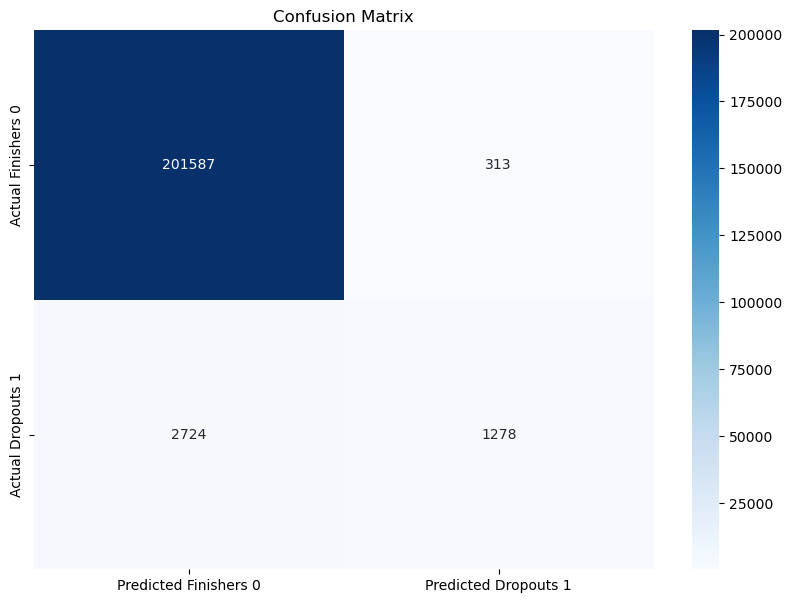

In [60]:
plot_confusion_matrix(y_test, (y_pred > 0.5).astype(int), class_names, title="Neural Network Normal Confusion Matrix")

### Extended SVMSMOTE Dataset:

In [9]:
print(f"Samples' Count Before Over-Sampling: {np.unique(y_train, return_counts=True)}")
# Define the over-sampling method.
svm_smote = SVMSMOTE(k_neighbors=5, m_neighbors=10, random_state=17)
############ N.B START This will take a long time. (45 minutes) ###############
# Apply over-sampling.
# X_train, y_train = svm_smote.fit_resample(X_train, y_train)
# np.save(f"{OTHER_DATA_PATH}/X_train_svmsmote.npy", X_train)
# np.save(f"{OTHER_DATA_PATH}/y_train_svmsmote.npy", y_train)
############ N.B END ###############
X_train = np.load(f"{OTHER_DATA_PATH}/X_train_svmsmote.npy")
y_train = np.load(f"{OTHER_DATA_PATH}/y_train_svmsmote.npy")
print(f"Samples' Count After Over-Sampling: {np.unique(y_train, return_counts=True)}")

Samples' Count Before Over-Sampling: (array([0, 1]), array([605698,  12007]))
Samples' Count After Over-Sampling: (array([0, 1]), array([605698, 605698]))


#### KNN:

In [10]:
knn_cls = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='distance')

In [11]:
knn_cls.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [12]:
y_pred = knn_cls.predict(X_test)
class_names = ["Finished", "Started"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Finished       0.99      0.95      0.97    201900
     Started       0.18      0.54      0.27      4002

    accuracy                           0.94    205902
   macro avg       0.58      0.75      0.62    205902
weighted avg       0.97      0.94      0.96    205902



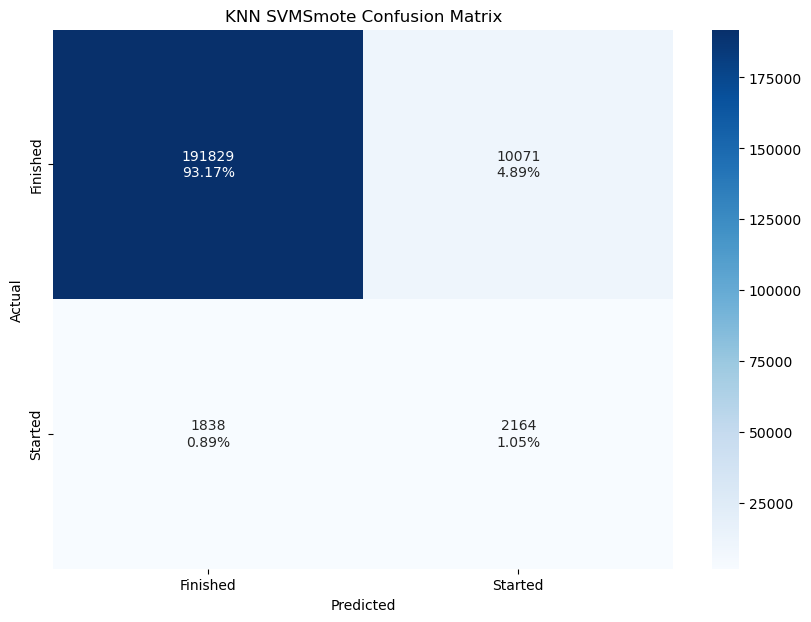

In [13]:
plot_confusion_matrix(y_test, y_pred, class_names, title="KNN SVMSmote Confusion Matrix")

In [14]:
save_sklearn_model(knn_cls, "KNN_SVMSmote", MODEL_SAVE_OVER)

Model saved to Models/Oversampled/KNN_SVMSmote.joblib


In [15]:
del knn_cls

#### Random Forest:

In [16]:
rfr_cls = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=2, min_samples_split=4, criterion='gini', random_state=17, n_jobs=-1)

In [17]:
rfr_cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=17)

<Axes: >

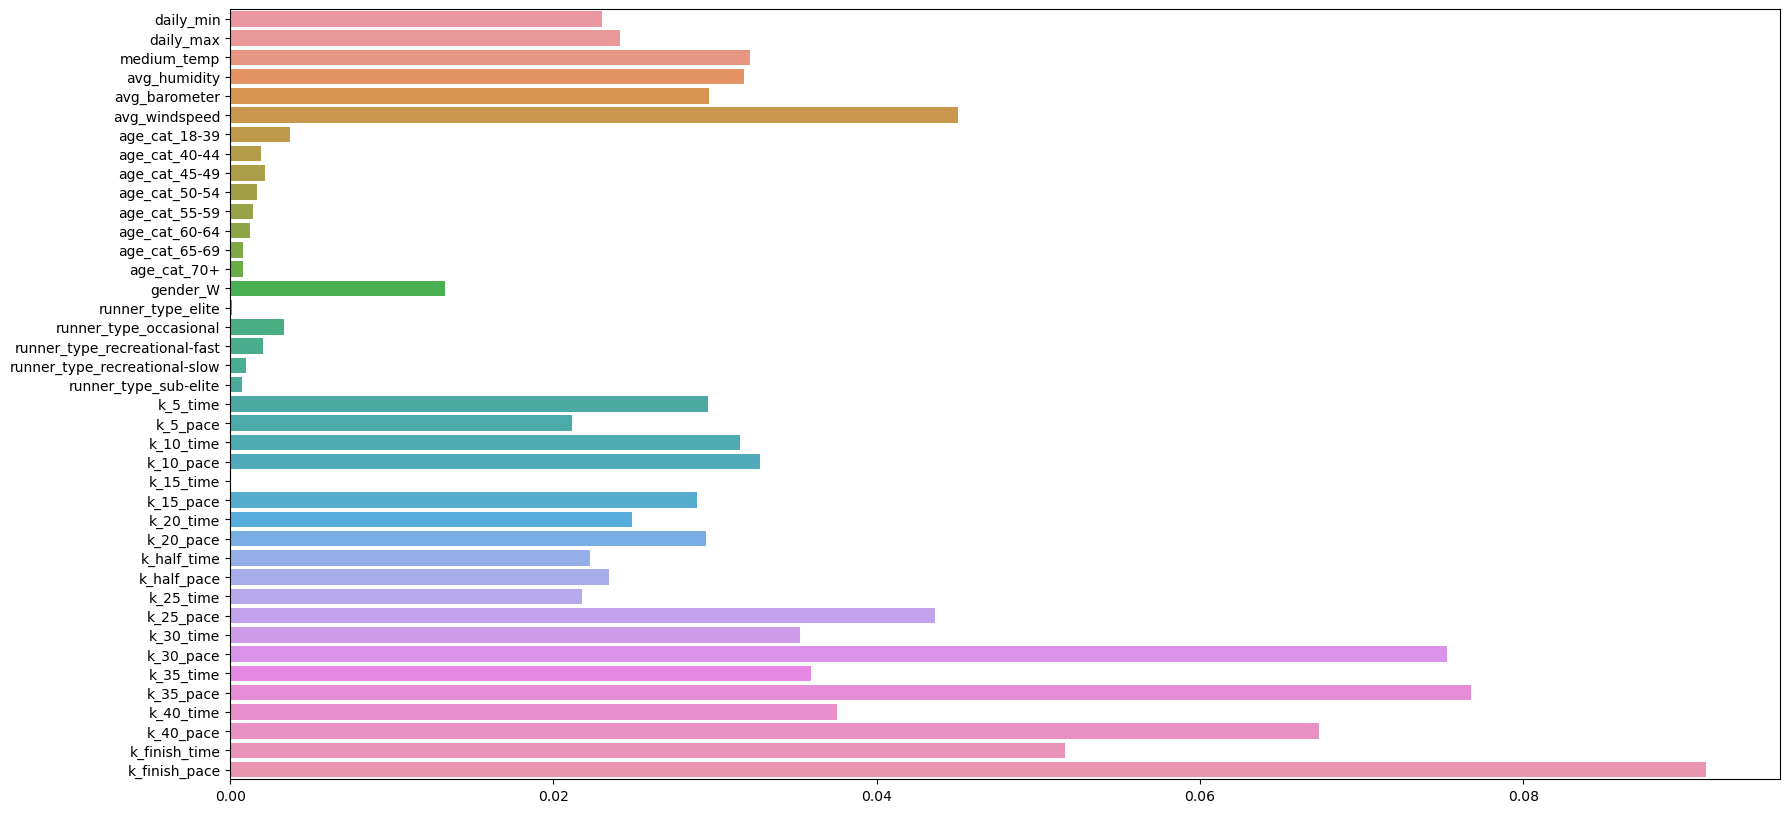

In [18]:
plt.figure(figsize=(20, 10))
sns.barplot(x=rfr_cls.feature_importances_, y=dataset_cols)

In [19]:
y_pred = rfr_cls.predict(X_test)
class_names = ["Finished", "Started"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Finished       0.99      0.97      0.98    201900
     Started       0.32      0.61      0.42      4002

    accuracy                           0.97    205902
   macro avg       0.66      0.79      0.70    205902
weighted avg       0.98      0.97      0.97    205902



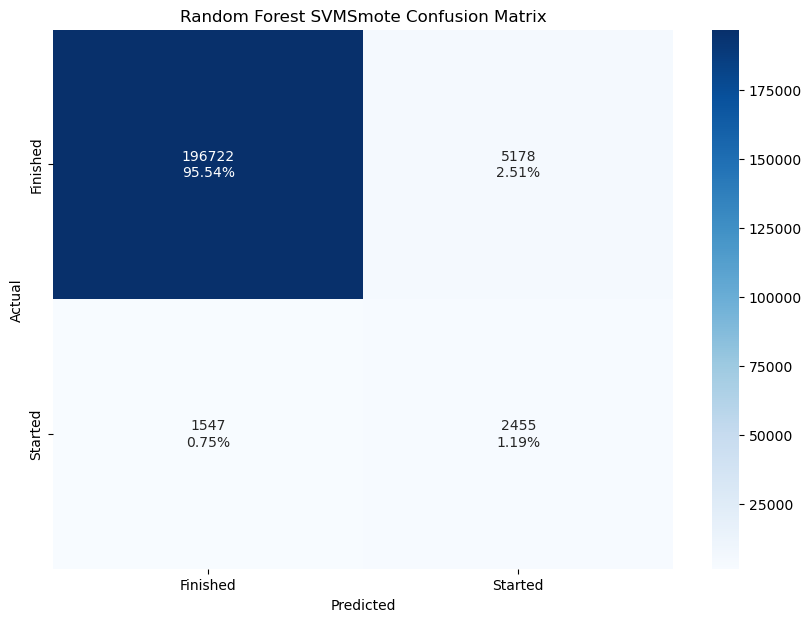

In [20]:
plot_confusion_matrix(y_test, y_pred, class_names, title="Random Forest SVMSmote Confusion Matrix")

In [21]:
save_sklearn_model(rfr_cls, "RandomForest_SVMSmote", MODEL_SAVE_OVER)

Model saved to Models/Oversampled/RandomForest_SVMSmote.joblib


In [22]:
del rfr_cls

#### Balanced Random Forest:

In [23]:
brf_cls = BalancedRandomForestClassifier(n_estimators=500, max_depth=20, sampling_strategy="all", replacement=True, 
                                         min_samples_leaf=2, min_samples_split=4, random_state=17, n_jobs=-1)

In [24]:
brf_cls.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=20, min_samples_leaf=2,
                               min_samples_split=4, n_estimators=500, n_jobs=-1,
                               random_state=17, replacement=True,
                               sampling_strategy='all')

<Axes: >

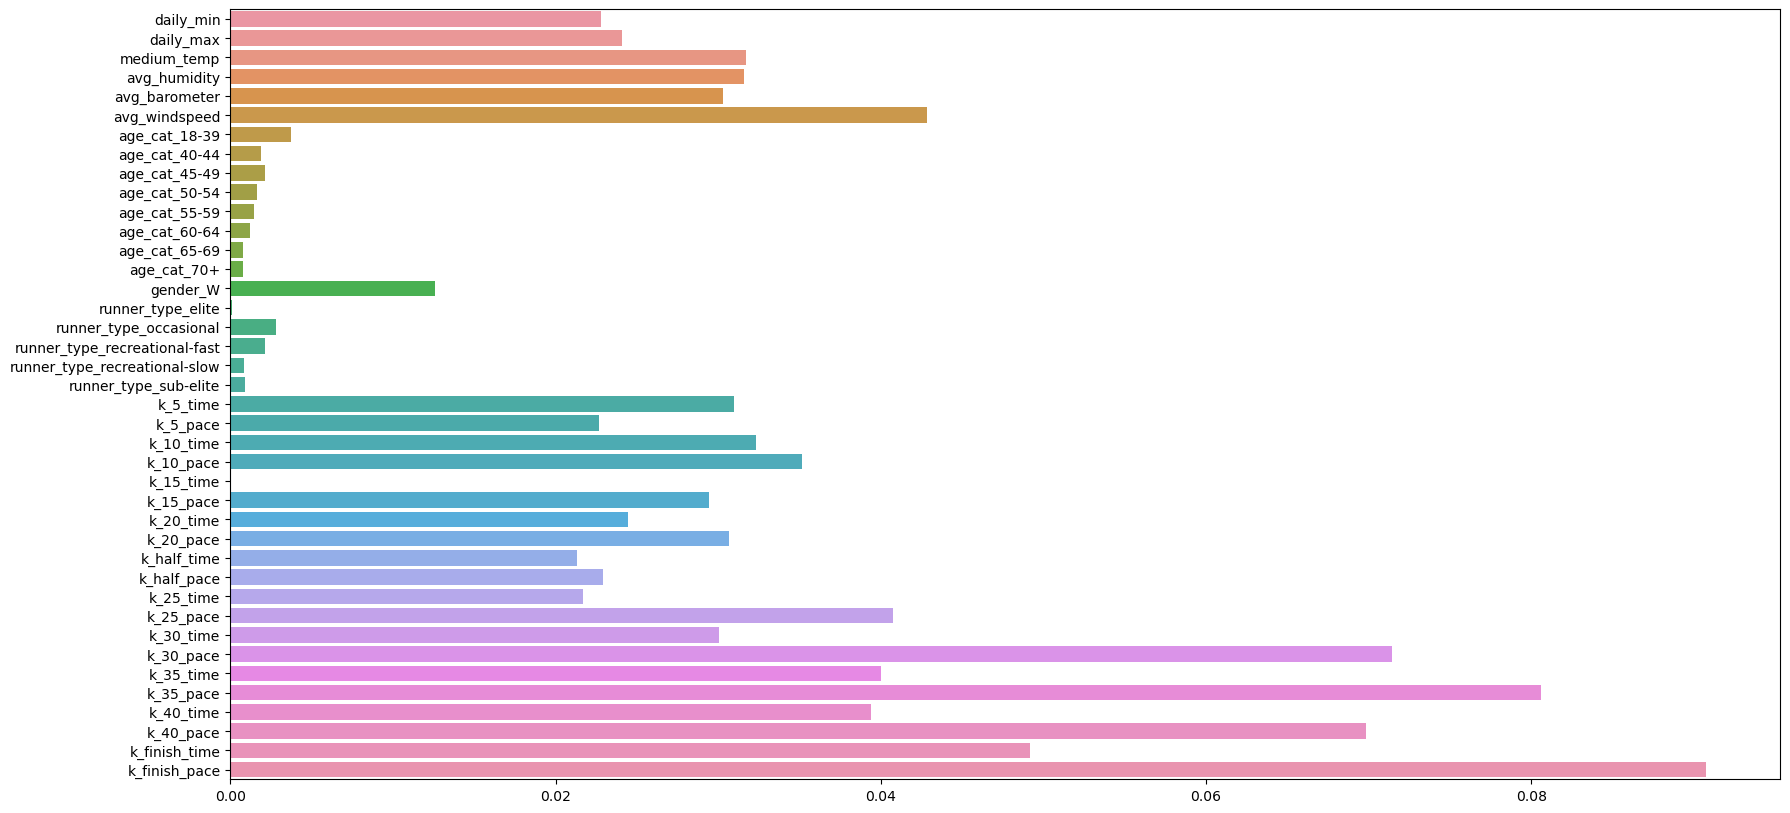

In [25]:
plt.figure(figsize=(20, 10))
sns.barplot(x=brf_cls.feature_importances_, y=dataset_cols)

In [26]:
y_pred = brf_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.97      0.98    201900
     Started       0.31      0.62      0.41      4002

    accuracy                           0.97    205902
   macro avg       0.65      0.80      0.70    205902
weighted avg       0.98      0.97      0.97    205902



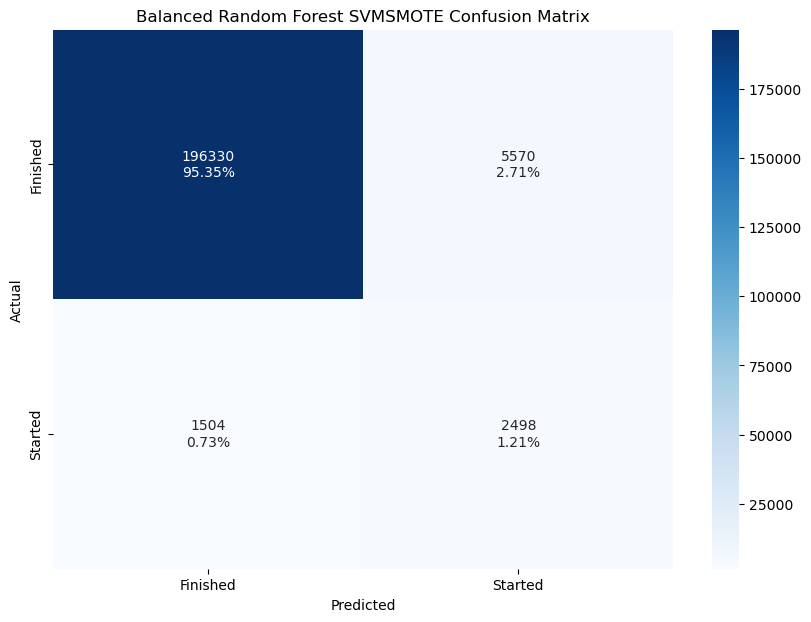

In [27]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="Balanced Random Forest SVMSMOTE Confusion Matrix")

In [28]:
save_sklearn_model(brf_cls, "BalancedRandomForest_SVMSmote", MODEL_SAVE_OVER)

Model saved to Models/Oversampled/BalancedRandomForest_SVMSmote.joblib


In [29]:
del brf_cls

#### XGBoost:

In [30]:
xgb_cls = XGBClassifier(n_estimators=200, max_depth=20, eval_metric="aucpr", max_delta_step=2, reg_lambda=3, 
                        reg_alpha=1, learning_rate=0.8, gamma=0.1, random_state=17, n_jobs=-1)

In [31]:
eval_set = [(X_val, y_val)]
xgb_cls.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-aucpr:0.36490
[1]	validation_0-aucpr:0.41938
[2]	validation_0-aucpr:0.45624
[3]	validation_0-aucpr:0.47799
[4]	validation_0-aucpr:0.49377
[5]	validation_0-aucpr:0.50684
[6]	validation_0-aucpr:0.51448
[7]	validation_0-aucpr:0.51645
[8]	validation_0-aucpr:0.52743
[9]	validation_0-aucpr:0.52671
[10]	validation_0-aucpr:0.53368
[11]	validation_0-aucpr:0.53711
[12]	validation_0-aucpr:0.53900
[13]	validation_0-aucpr:0.54076
[14]	validation_0-aucpr:0.54542
[15]	validation_0-aucpr:0.54488
[16]	validation_0-aucpr:0.54497
[17]	validation_0-aucpr:0.54491
[18]	validation_0-aucpr:0.54500
[19]	validation_0-aucpr:0.54839
[20]	validation_0-aucpr:0.54837
[21]	validation_0-aucpr:0.55091
[22]	validation_0-aucpr:0.55100
[23]	validation_0-aucpr:0.55095
[24]	validation_0-aucpr:0.55072
[25]	validation_0-aucpr:0.55177
[26]	validation_0-aucpr:0.55458
[27]	validation_0-aucpr:0.55537
[28]	validation_0-aucpr:0.55659
[29]	validation_0-aucpr:0.55927
[30]	validation_0-aucpr:0.56026
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=2,
              max_depth=20, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=17, ...)

<Axes: >

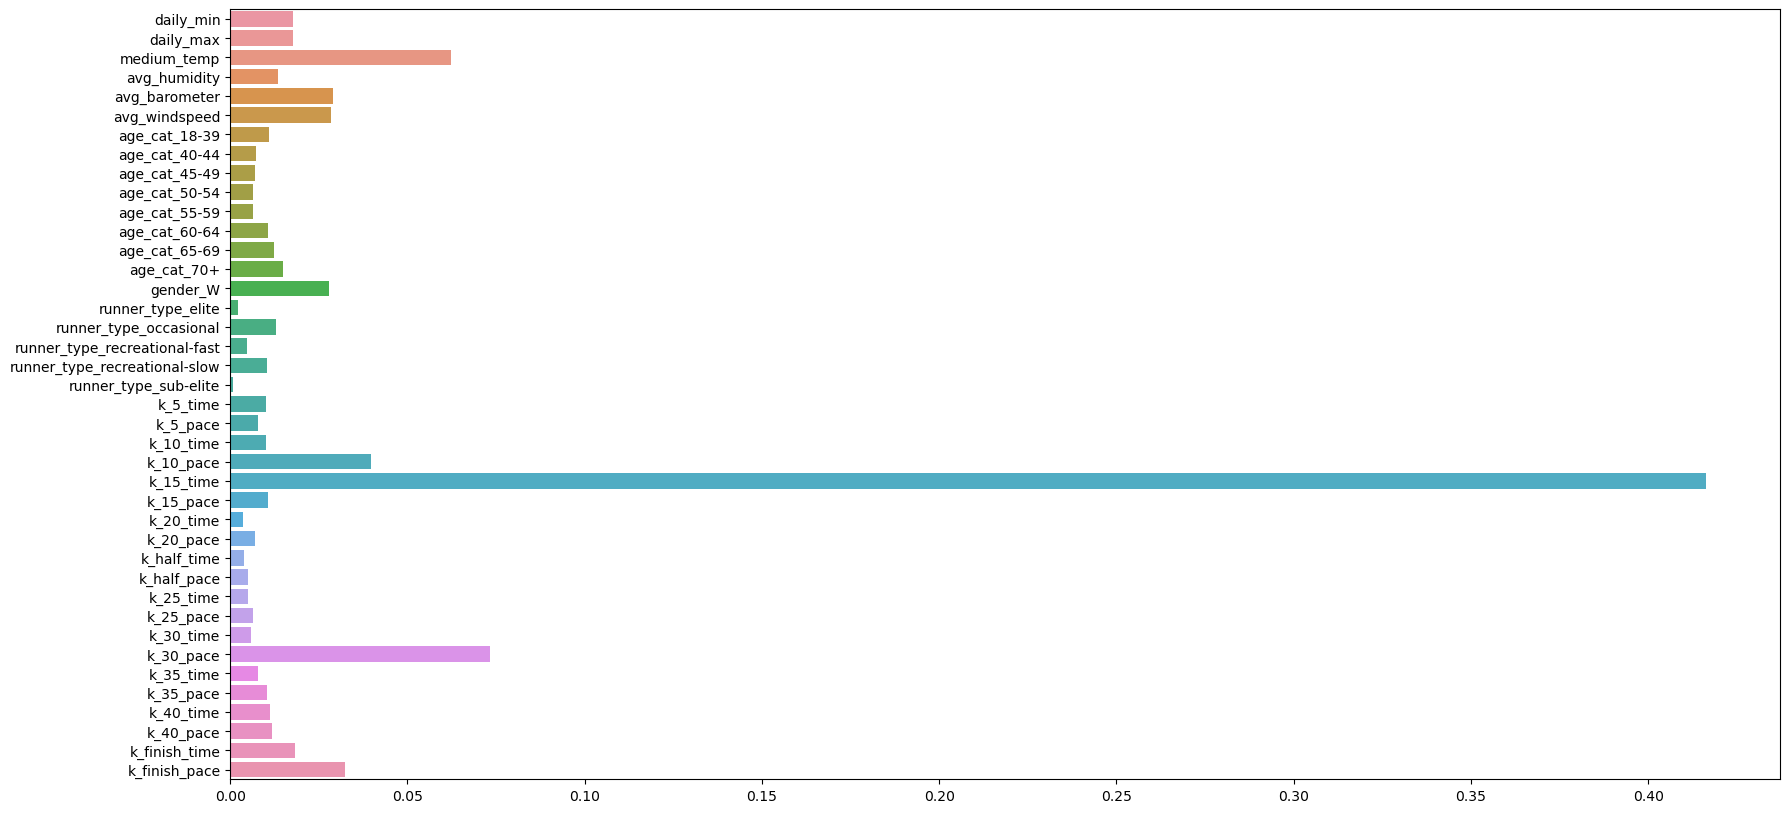

In [32]:
plt.figure(figsize=(20, 10))
sns.barplot(x=xgb_cls.feature_importances_, y=dataset_cols)

In [33]:
y_pred = xgb_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.99      0.99    201900
     Started       0.60      0.55      0.57      4002

    accuracy                           0.98    205902
   macro avg       0.80      0.77      0.78    205902
weighted avg       0.98      0.98      0.98    205902



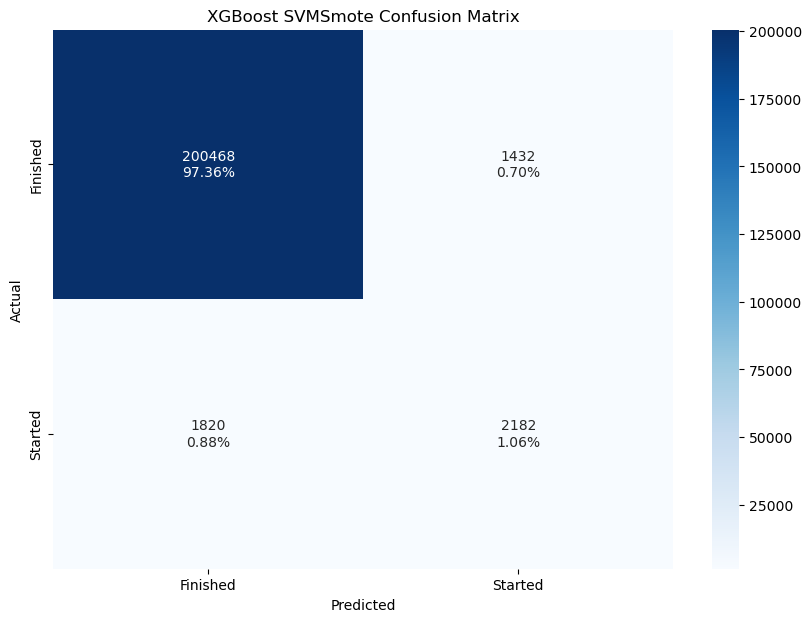

In [34]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="XGBoost SVMSmote Confusion Matrix")

In [35]:
xgb_cls.save_model(f"{MODEL_SAVE_OVER}XGBoost_SVMSmote.json")

In [36]:
del xgb_cls

#### Neural Network:

### Extended SMOTEENN Dataset:

In [9]:
# IMPORTANT: Ensure that X_train and y_train are the original extended data and not the over-sampled data.
print(f"Samples' Count Before Over-Sampling: {np.unique(y_train, return_counts=True)}")
# Define the under-sampling method.
enn = EditedNearestNeighbours(n_neighbors=5, n_jobs=-1)
# Define the over-sampling method.
smote = SMOTE(k_neighbors=5)
# Define the hybrid method.
smote_enn = SMOTEENN(smote=smote, enn=enn, random_state=17)
############ N.B This will take a long time. (6 minutes) ###############
# Apply over-sampling.
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)
# np.save(f"{OTHER_DATA_PATH}/X_train_smoteenn.npy", X_train)
# np.save(f"{OTHER_DATA_PATH}/y_train_smoteen.npy", y_train)
############ N.B END ###############
X_train = np.load(f"{OTHER_DATA_PATH}/X_train_smoteenn.npy")
y_train = np.load(f"{OTHER_DATA_PATH}/y_train_smoteen.npy")
print(f"Samples' Count After Over-Sampling: {np.unique(y_train, return_counts=True)}")

Samples' Count Before Over-Sampling: (array([0, 1]), array([605698,  12007]))
Samples' Count After Over-Sampling: (array([0, 1]), array([605698, 600573]))


#### KNN:

In [11]:
knn_cls = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='distance')

In [12]:
knn_cls.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [13]:
y_pred = knn_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.92      0.95    201900
     Started       0.13      0.60      0.21      4002

    accuracy                           0.91    205902
   macro avg       0.56      0.76      0.58    205902
weighted avg       0.97      0.91      0.94    205902



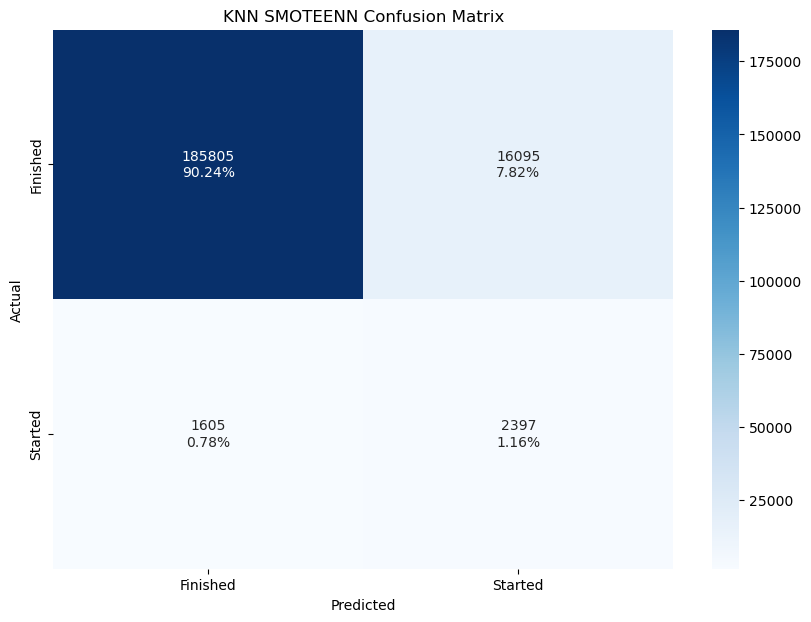

In [14]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="KNN SMOTEENN Confusion Matrix")

In [15]:
save_sklearn_model(knn_cls, "KNN_SMOTEENN", MODEL_SAVE_HYBRID)

Model saved to Models/Hybrid/KNN_SMOTEENN.joblib


In [16]:
del knn_cls

#### Random Forest:

In [23]:
rfr_cls = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=2, min_samples_split=4, criterion='gini', random_state=17, n_jobs=-1)

In [24]:
rfr_cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=17)

<Axes: >

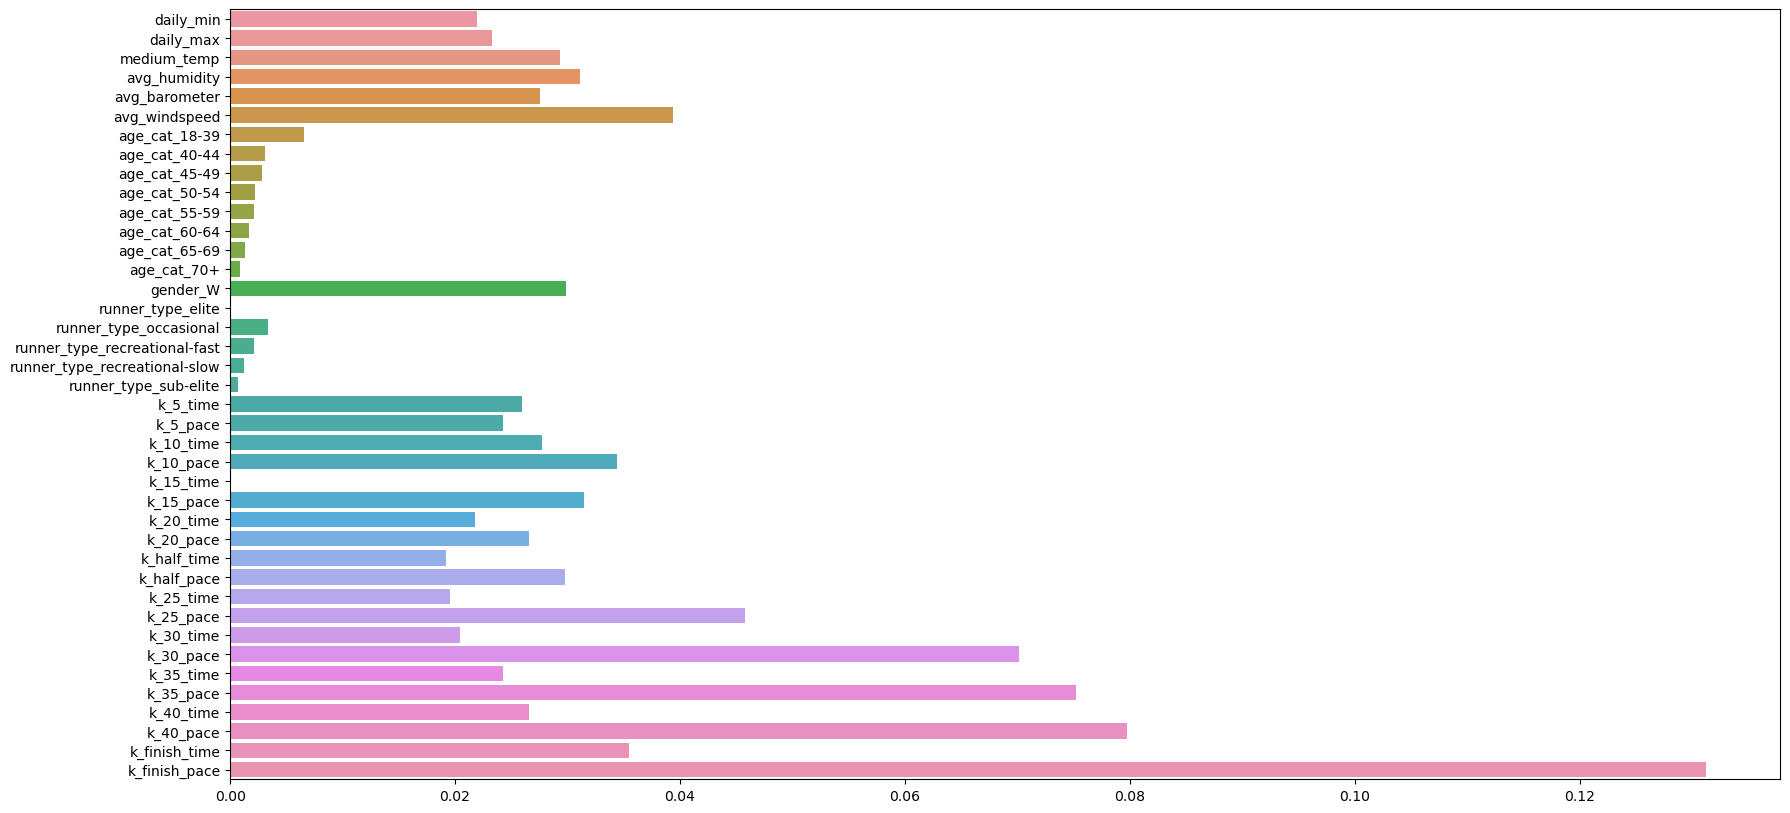

In [25]:
plt.figure(figsize=(20, 10))
sns.barplot(x=rfr_cls.feature_importances_, y=dataset_cols)

In [26]:
y_pred = rfr_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.95      0.97    201900
     Started       0.23      0.71      0.35      4002

    accuracy                           0.95    205902
   macro avg       0.61      0.83      0.66    205902
weighted avg       0.98      0.95      0.96    205902



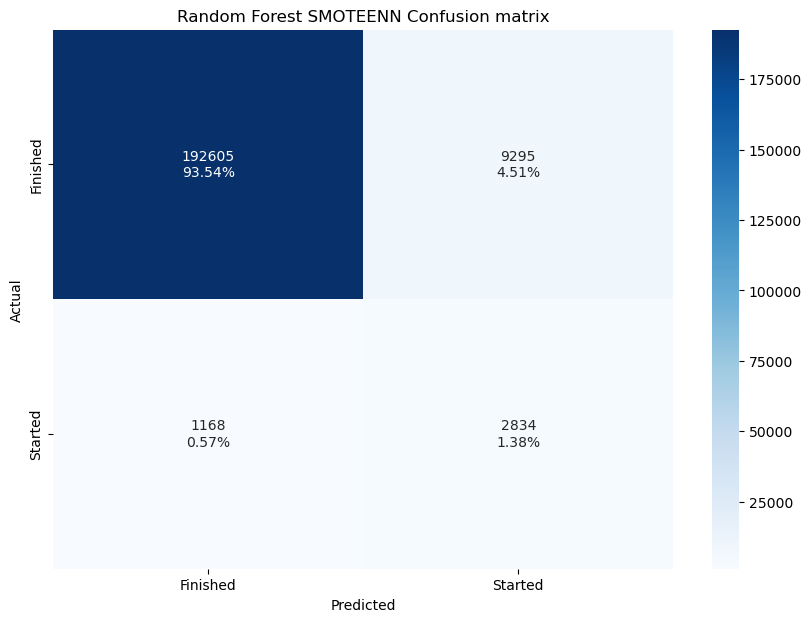

In [27]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title='Random Forest SMOTEENN Confusion matrix')

In [28]:
save_sklearn_model(rfr_cls, "RandomForest_SMOTEENN", MODEL_SAVE_HYBRID)

Model saved to Models/Hybrid/RandomForest_SMOTEENN.joblib


In [29]:
del rfr_cls

#### Balanced Random Forest:

In [30]:
brf_cls = BalancedRandomForestClassifier(n_estimators=500, max_depth=20, sampling_strategy="all", replacement=True, 
                                         min_samples_leaf=2, min_samples_split=4, random_state=17, n_jobs=-1)

In [31]:
brf_cls.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=20, min_samples_leaf=2,
                               min_samples_split=4, n_estimators=500, n_jobs=-1,
                               random_state=17, replacement=True,
                               sampling_strategy='all')

<Axes: >

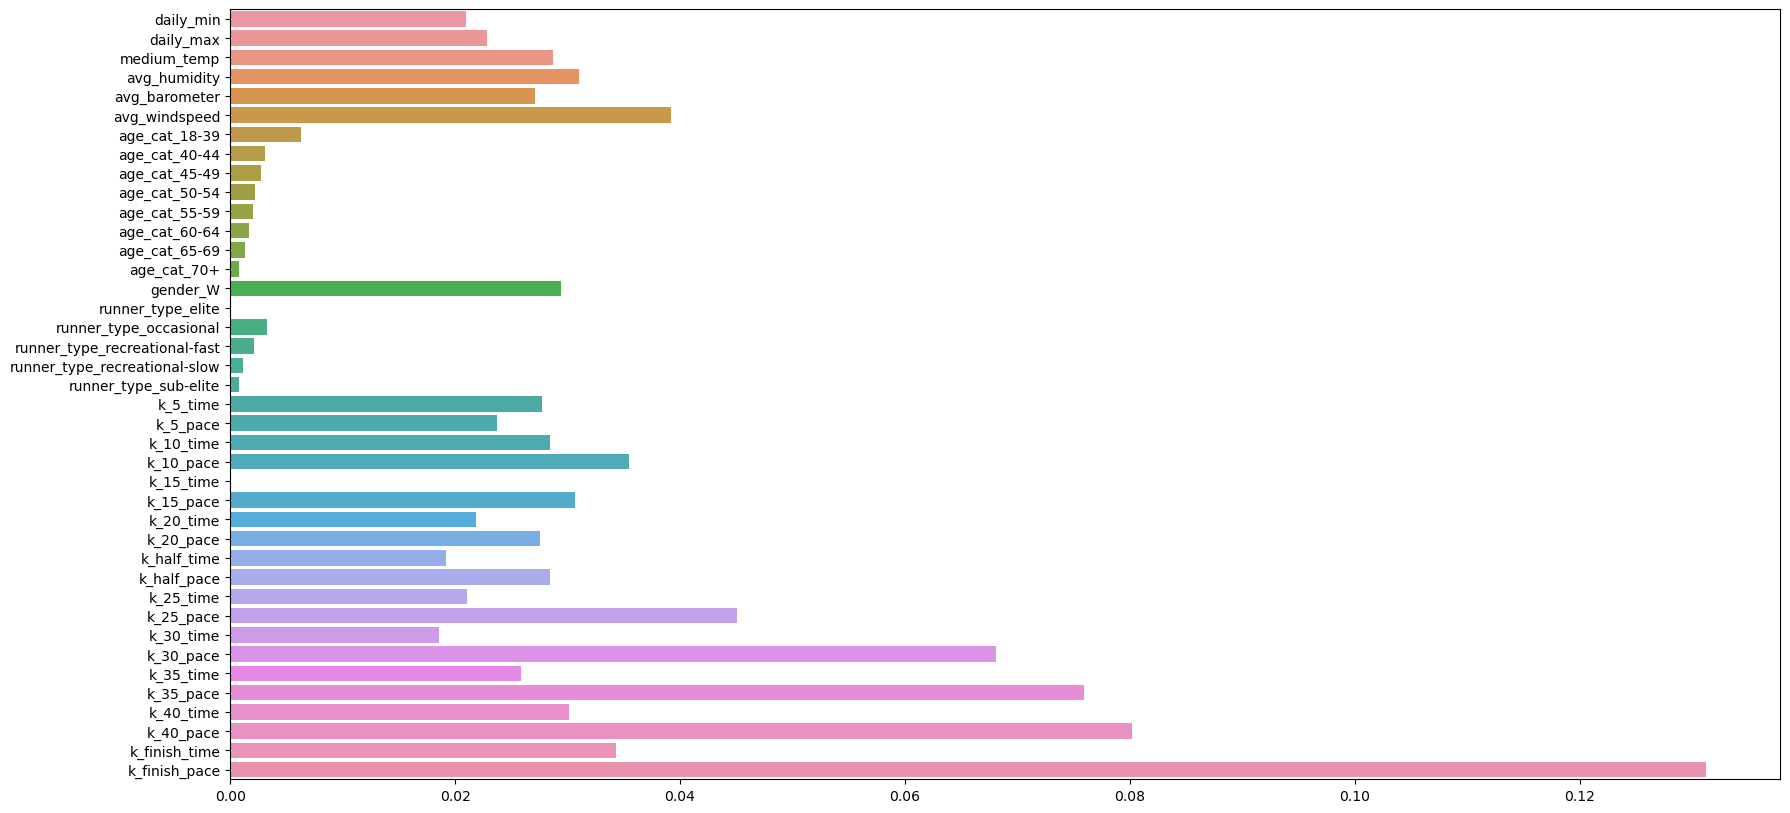

In [32]:
plt.figure(figsize=(20, 10))
sns.barplot(x=brf_cls.feature_importances_, y=dataset_cols)

In [33]:
y_pred = brf_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.95      0.97    201900
     Started       0.22      0.72      0.34      4002

    accuracy                           0.95    205902
   macro avg       0.61      0.83      0.66    205902
weighted avg       0.98      0.95      0.96    205902



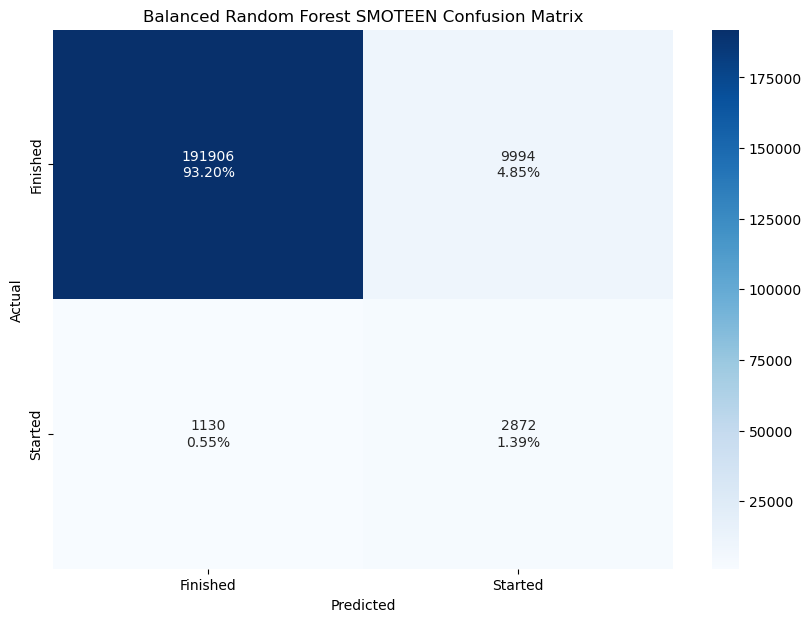

In [34]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="Balanced Random Forest SMOTEEN Confusion Matrix")

In [35]:
save_sklearn_model(brf_cls, "BalancedRandomForest_SMOTEENN", MODEL_SAVE_HYBRID)

Model saved to Models/Oversampled/BalancedRandomForest_SMOTEENN.joblib


In [36]:
del brf_cls

#### XGBoost:

In [37]:
xgb_cls = XGBClassifier(n_estimators=200, max_depth=20, eval_metric="aucpr", max_delta_step=2, reg_lambda=3, 
                        reg_alpha=1, learning_rate=0.8, gamma=0.1, random_state=17, n_jobs=-1)

In [38]:
eval_set = [(X_val, y_val)]
xgb_cls.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-aucpr:0.38677
[1]	validation_0-aucpr:0.41780
[2]	validation_0-aucpr:0.44521
[3]	validation_0-aucpr:0.46930
[4]	validation_0-aucpr:0.47952
[5]	validation_0-aucpr:0.48140
[6]	validation_0-aucpr:0.49716
[7]	validation_0-aucpr:0.51369
[8]	validation_0-aucpr:0.51561
[9]	validation_0-aucpr:0.51673
[10]	validation_0-aucpr:0.51729
[11]	validation_0-aucpr:0.52088
[12]	validation_0-aucpr:0.52550
[13]	validation_0-aucpr:0.52840
[14]	validation_0-aucpr:0.52988
[15]	validation_0-aucpr:0.53129
[16]	validation_0-aucpr:0.53321
[17]	validation_0-aucpr:0.53357
[18]	validation_0-aucpr:0.53341
[19]	validation_0-aucpr:0.53287
[20]	validation_0-aucpr:0.53363
[21]	validation_0-aucpr:0.53476
[22]	validation_0-aucpr:0.53450
[23]	validation_0-aucpr:0.53744
[24]	validation_0-aucpr:0.53780
[25]	validation_0-aucpr:0.54141
[26]	validation_0-aucpr:0.54246
[27]	validation_0-aucpr:0.54208
[28]	validation_0-aucpr:0.54361
[29]	validation_0-aucpr:0.54656
[30]	validation_0-aucpr:0.54603
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=2,
              max_depth=20, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=17, ...)

<Axes: >

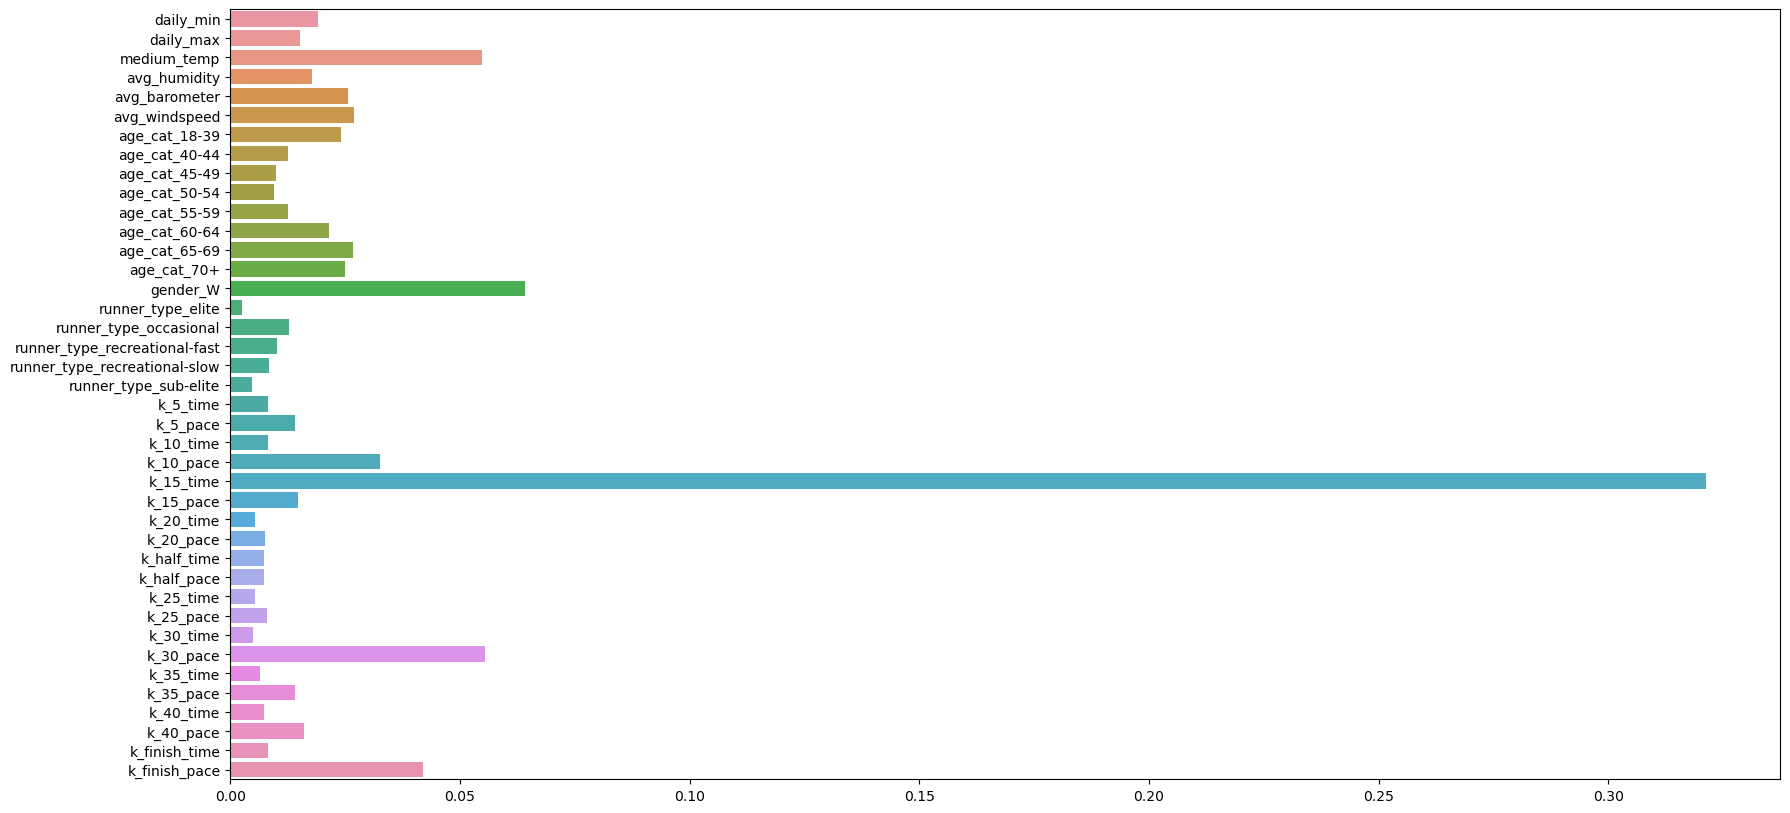

In [39]:
plt.figure(figsize=(20, 10))
sns.barplot(x=xgb_cls.feature_importances_, y=dataset_cols)

In [40]:
y_pred = xgb_cls.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Finished       0.99      0.99      0.99    201900
     Started       0.62      0.52      0.57      4002

    accuracy                           0.98    205902
   macro avg       0.80      0.76      0.78    205902
weighted avg       0.98      0.98      0.98    205902



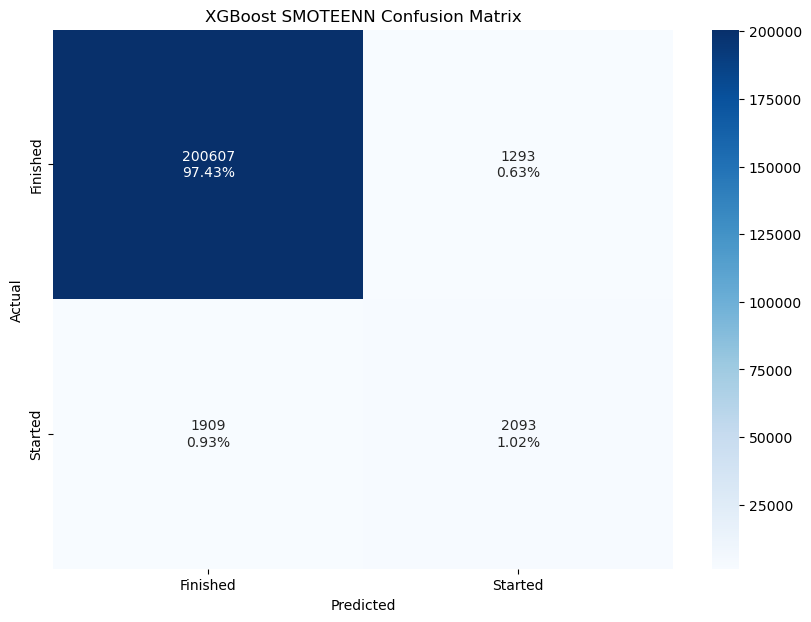

In [41]:
plot_confusion_matrix(y_test, y_pred, CLASS_NAMES, title="XGBoost SMOTEENN Confusion Matrix")

In [42]:
xgb_cls.save_model(f"{MODEL_SAVE_HYBRID}XGBoost_SMOTEENN.json")

In [43]:
del xgb_cls

#### Neural Network:

## Marathon Performance Prediction:

In [111]:
## DATA PREPARATION
from utils.model_utils import transform_skewed_features, transform_cols
from pprint import pprint
from sklearn.preprocessing import PowerTransformer

def get_reg_preprocessed_datasets(df: pd.DataFrame, target_scaler, cols_order: list[str], splits_cols: list[str], test_split: float = 0.2, val_split: float = 0.25, random_state: int = 17, 
                                  return_cols: bool = False, last_split: int = 10, return_full_data: bool = False):
    """
    ### Get the preprocessed datasets.
    ----
    ### Arguments:
    + df: The DataFrame.
    + target_scaler: The scaler to be used to scale the target variable.
    + cols_order: The columns order.
    + splits_cols: The splits columns.
    + test_split: The test split.
    + val_split: The validation split.
    + random_state: The random state.
    + return_cols: Whether to return the columns or not.
    + last_split: The last split to be used. `None` means all splits will be used.
    ['5k': 1, '10k': 2, '15k': 3, '20k': 4, 'half': 5, '25k': 6, '30k': 7, '35k': 8, '40k': 9]
    + return_full_data: Whether to return the full data before splitting or not.
    ----
    ### Returns:
    + (X_train, y_train): The training set.
    + (X_test, y_test): The test set.
    + (X_val, y_val): The validation set.
    """
    # the last split is not used since it is the target variable.
    assert last_split <= 9, "last_split must be less than or equal to 9."
    # Transform skewed features.
    tmp_df = transform_skewed_features(df, cols_order)
    # Transform the columns.
    tmp_df = transform_cols(df, splits_cols)

    # Define the columns to be used to train the model.
    cols_names = tmp_df.columns.to_list()
    # N.B Set could be used instead of list, but the order of the columns will be lost, plus the list is small.
    # Only one gender column is used, since it is a binary column.
    non_split_cols = [
        col for col in cols_names if col not in splits_cols and col != "gender_M"
    ]
    # the speed cols are not used since they are highly correlated with the pace cols.
    used_split_cols = [
        item for item in cols_names if "_time" in item or "_pace" in item
    ][: last_split * 2]
    used_cols = non_split_cols + used_split_cols
    pprint(f"The columns to be used: {used_cols}")

    # Main DataFrame.
    X = tmp_df[used_cols]

    # Encoding the target variable.
    # Gettting the target variable.
    y = df["k_finish_time"].to_numpy()
    transformer = PowerTransformer(standardize=True)
    y = transformer.fit_transform(y.reshape(-1, 1)).flatten()
    # y = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()
    
    # Splitting The data into train, validation and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X.to_numpy(), y, test_size=test_split, random_state=random_state
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=val_split,
        random_state=random_state,
    )

    if return_cols:
        return (X_train, y_train), (X_test, y_test), (X_val, y_val), transformer, used_cols
    return (X_train, y_train), (X_test, y_test), (X_val, y_val), transformer

In [112]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# rbs_scaler = RobustScaler()
std_scaler = StandardScaler()
# minmax_scaler = MinMaxScaler()

In [113]:
# Only keeping the runner who finished.
df_data_finishers = df_data[df_data["race_state"] == "Finished"].reset_index(drop=True)

In [114]:
train, test, val, p_transformer, dataset_cols = get_reg_preprocessed_datasets(df_data_finishers, std_scaler, COLUMNS_ORDER, SPLITS_ORDER, return_cols=True, last_split=5)
# get_reg_preprocessed_datasets(df_data_finishers, std_scaler, COLUMNS_ORDER, SPLITS_ORDER, return_cols=True, last_split=2)

Transforming skewed features...

Transforming columns (oneHotEncoding and Scaling)...

("The columns to be used: ['daily_min', 'daily_max', 'medium_temp', "
 "'avg_humidity', 'avg_barometer', 'avg_windspeed', 'age_cat_18-39', "
 "'age_cat_40-44', 'age_cat_45-49', 'age_cat_50-54', 'age_cat_55-59', "
 "'age_cat_60-64', 'age_cat_65-69', 'age_cat_70+', 'gender_W', "
 "'runner_type_elite', 'runner_type_occasional', "
 "'runner_type_recreational-fast', 'runner_type_recreational-slow', "
 "'runner_type_sub-elite', 'k_5_time', 'k_5_pace', 'k_10_time', 'k_10_pace', "
 "'k_15_time', 'k_15_pace', 'k_20_time', 'k_20_pace', 'k_half_time', "
 "'k_half_pace']")


In [115]:
X_train, y_train = train
X_test, y_test = test
X_val, y_val = val

In [116]:
y_train

array([ 0.70474174,  0.10991256,  1.1076318 , ..., -0.12959276,
       -0.5194961 , -2.51144808])

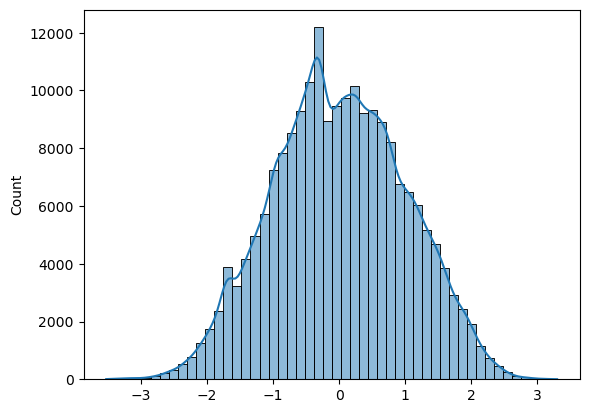

In [117]:
sns.histplot(y_test, bins=50, kde=True);

### KNN:

In [42]:
knn_reg = KNeighborsRegressor(n_neighbors=10, n_jobs=-1, weights='distance')

In [ ]:
cv_score = cross_val_score(knn_reg, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

In [43]:
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1, n_neighbors=10, weights='distance')

In [44]:
y_pred = knn_reg.predict(X_test)

In [45]:
y_pred_unscaled = rbs_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

In [46]:
y_pred_unscaled

array([14267.79773824, 21113.45251289, 16126.96512937, ...,
       22859.14296186, 11151.76887511, 14208.73769892])

In [47]:
y_test_unscaled = rbs_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [48]:
y_test_unscaled

array([14917., 20453., 15500., ..., 22835., 10998., 13838.])

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled, squared=False).round(0)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled).round(0)
mape = (mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled)*100).round(2)
print(f"Mean Squared Error: {mse}\n")
print(f"Mean Absolute Error: {mae}\n")
print(f"Mean Absolute Percentage Error: {mape}%\n")

Mean Squared Error: 725.0

Mean Absolute Error: 530.0

Mean Absolute Percentage Error: 3.32%



In [ ]:
# save_sklearn_model(knn_cls, "KNN", MODEL_SAVE_NORMAL)

In [50]:
del knn_reg

### Random Forest:

In [46]:
rfr_rgr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=17, n_jobs=-1)

In [47]:
rfr_rgr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=17)

<Axes: >

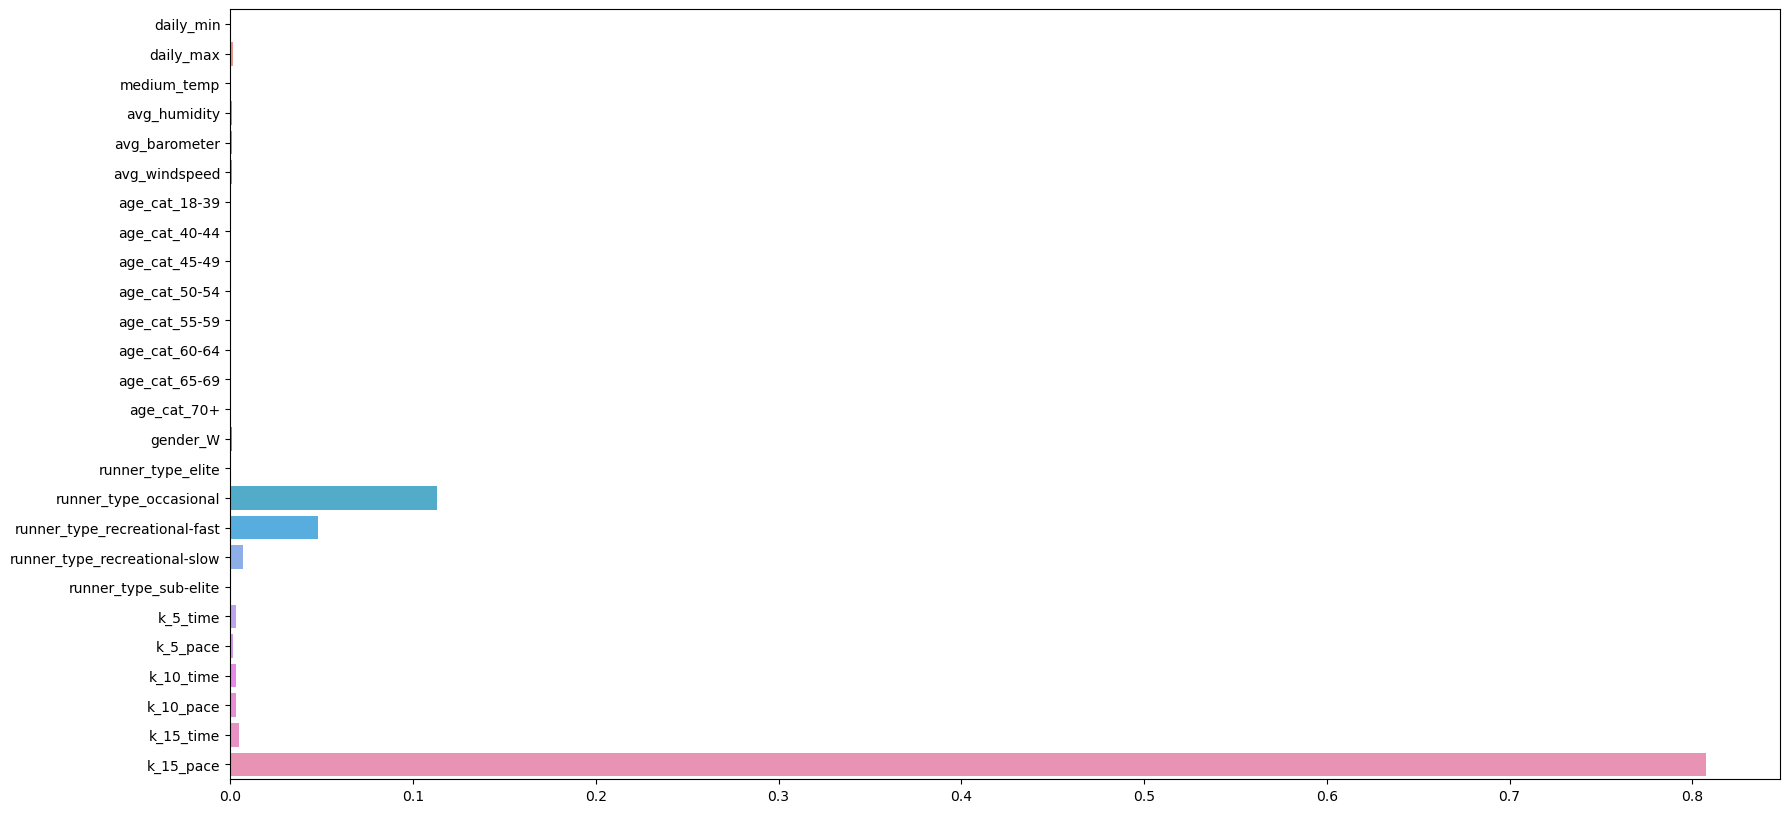

In [48]:
plt.figure(figsize=(20, 10))
sns.barplot(x=rfr_rgr.feature_importances_, y=dataset_cols)

In [49]:
y_pred = rfr_rgr.predict(X_test)

In [50]:
y_pred_unscaled = p_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_unscaled = p_transformer.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [ ]:
cv_5 = cross_val_score(rfr_rgr, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
print(f"Mean Cross Validation Score k=5: {cv_5}\n")

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled, squared=False).round(0)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled).round(0)
mape = (mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled)*100).round(2)
print(f"Mean Squared Error: {mse}\n")
print(f"Mean Absolute Error: {mae}\n")
print(f"Mean Absolute Percentage Error: {mape}%\n")

Mean Squared Error: 687.0

Mean Absolute Error: 505.0

Mean Absolute Percentage Error: 3.16%



In [ ]:
# save_sklearn_model(rfr_rgr, "RandomForest", MODEL_SAVE_NORMAL)

In [59]:
del rfr_rgr

### XGBoost:

In [135]:
# xgb_rgr = XGBRegressor(n_estimators=100, max_depth=20, random_state=17, eval_metric="mae", n_jobs=-1, max_delta_step=2, reg_lambda=3, reg_alpha=1, eta=0.2)
xgb_rgr = XGBRegressor(objective="reg:squarederror",eval_metric=["mae", "rmse"], n_jobs=-1, random_state=17)

In [136]:
xgb_rgr.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-mae:0.64761	validation_0-rmse:0.79212	validation_1-mae:0.64931	validation_1-rmse:0.79394
[1]	validation_0-mae:0.46545	validation_0-rmse:0.56766	validation_1-mae:0.46666	validation_1-rmse:0.56897
[2]	validation_0-mae:0.34024	validation_0-rmse:0.41494	validation_1-mae:0.34114	validation_1-rmse:0.41585
[3]	validation_0-mae:0.25658	validation_0-rmse:0.31347	validation_1-mae:0.25724	validation_1-rmse:0.31414
[4]	validation_0-mae:0.20269	validation_0-rmse:0.24852	validation_1-mae:0.20308	validation_1-rmse:0.24900
[5]	validation_0-mae:0.16947	validation_0-rmse:0.20900	validation_1-mae:0.16974	validation_1-rmse:0.20934
[6]	validation_0-mae:0.14942	validation_0-rmse:0.18626	validation_1-mae:0.14967	validation_1-rmse:0.18654
[7]	validation_0-mae:0.13740	validation_0-rmse:0.17371	validation_1-mae:0.13764	validation_1-rmse:0.17392
[8]	validation_0-mae:0.13017	validation_0-rmse:0.16694	validation_1-mae:0.13041	validation_1-rmse:0.16713
[9]	validation_0-mae:0.12587	validation_0-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=17, ...)

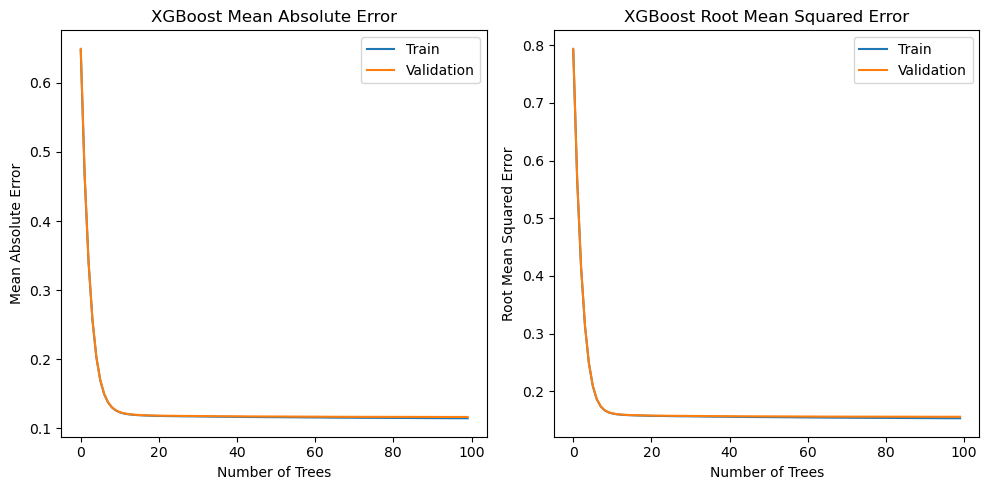

In [137]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(xgb_rgr.evals_result_["validation_0"]["mae"], label="Train")
plt.plot(xgb_rgr.evals_result_["validation_1"]["mae"], label="Validation")
plt.legend()
plt.xlabel("Number of Trees")
plt.ylabel("Mean Absolute Error")
plt.title("XGBoost Mean Absolute Error")

plt.subplot(1, 2, 2)
plt.plot(xgb_rgr.evals_result_["validation_0"]["rmse"], label="Train")
plt.plot(xgb_rgr.evals_result_["validation_1"]["rmse"], label="Validation")
plt.legend()
plt.xlabel("Number of Trees")
plt.ylabel("Root Mean Squared Error")
plt.title("XGBoost Root Mean Squared Error")
plt.tight_layout()
plt.show()

In [110]:
cv_score = cross_val_score(xgb_rgr, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
print(f"Cross Validation Score k={K_FOLD_NUM}: {cv_score.mean():.3f} ({cv_score.std():.3f})")

Cross Validation Score k=5: -0.006 (0.000)


<Axes: >

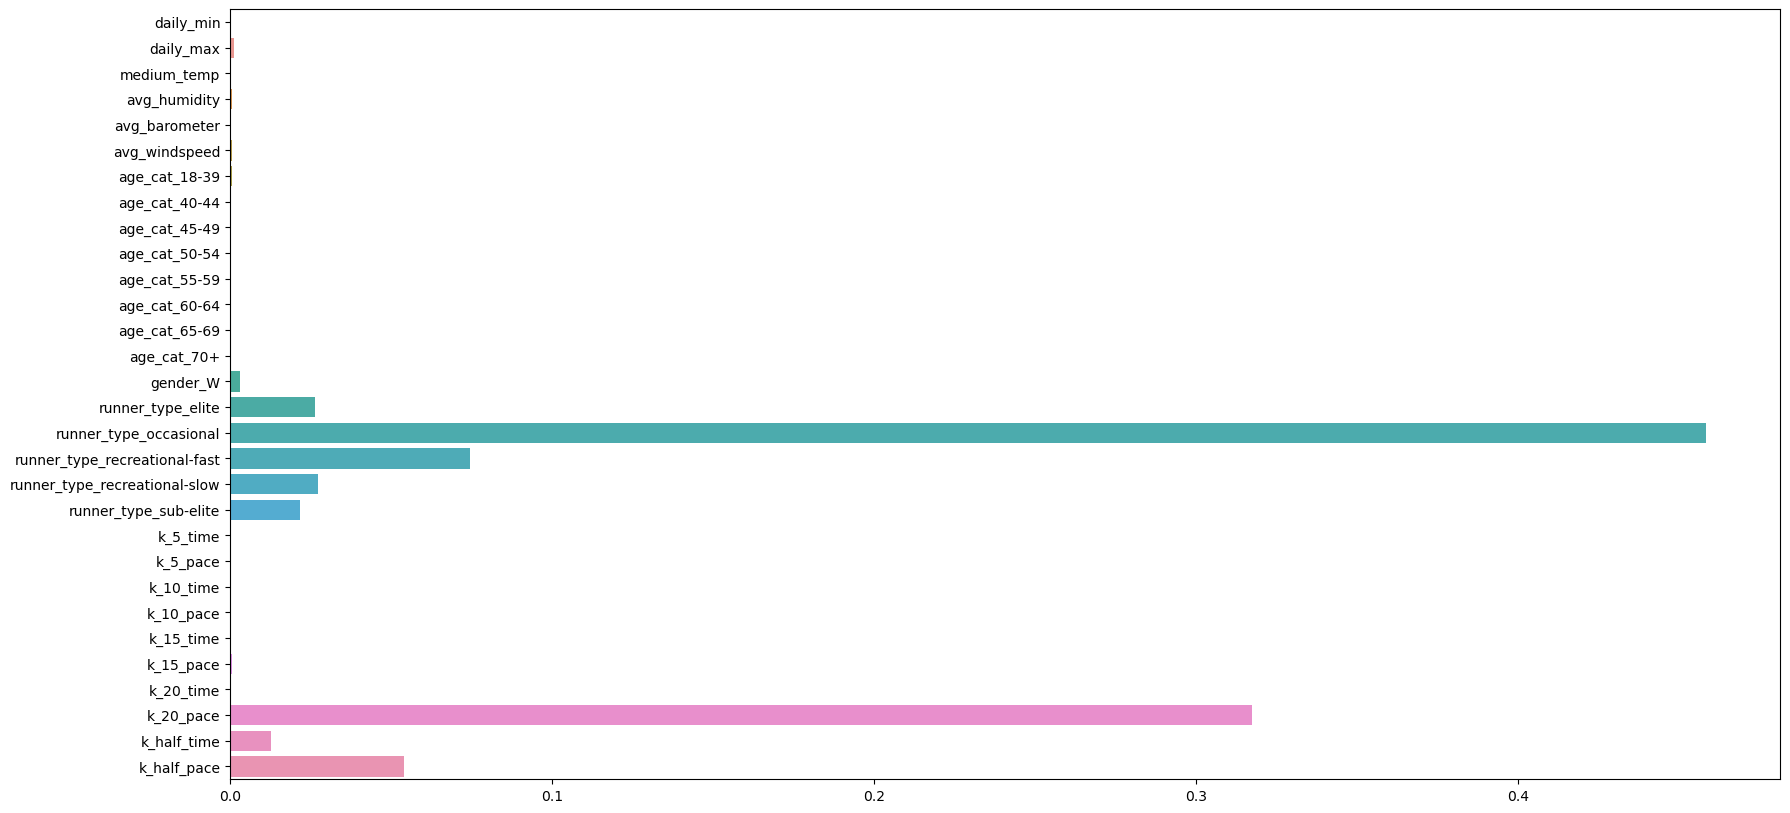

In [138]:
plt.figure(figsize=(20, 10))
sns.barplot(x=xgb_rgr.feature_importances_, y=dataset_cols)

In [139]:
y_pred = xgb_rgr.predict(X_test)

In [140]:
# Get the unscaled y_pred, since the target variable was scaled before training the model.
y_pred_unscaled = p_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# Get the unscaled y_test.
y_test_unscaled = p_transformer.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [145]:
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled, squared=False).round(0)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled).round(0)
mape = (mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled)*100).round(2)
r2 = r2_score(y_test_unscaled, y_pred_unscaled).round(2)
print(f"Mean Squared Error: {mse} seconds, {mse/60} minutes\n")
print(f"Mean Absolute Error: {mae} seconds, {mae/60} minutes\n")
print(f"Mean Absolute Percentage Error: {mape}%\n")
print(f"R2 Score: {r2}\n")

Mean Squared Error: 549.0 seconds, 9.15 minutes

Mean Absolute Error: 395.0 seconds, 6.583333333333333 minutes

Mean Absolute Percentage Error: 2.47%

R2 Score: 0.97



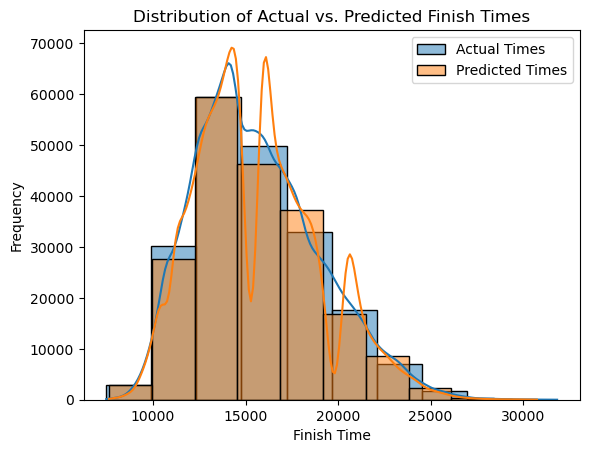

In [125]:
# import matplotlib.pyplot as plt
# Create scatter plot
# plt.scatter(y_test_unscaled, y_test_unscaled, color='blue', marker='o', label='Actual Times')
# plt.scatter(y_test_unscaled, y_pred_unscaled, color='red', marker='x', label='Predicted Times')
# plt.plot([min(y_test_unscaled), max(y_test_unscaled)], 
#          [min(y_test_unscaled), max(y_test_unscaled)], 
#          color='green', linestyle='--', label='Line of Equality')
# plt.legend()
# plt.xlabel('Actual Finish Time')
# plt.ylabel('Predicted Finish Time')
# plt.title('Actual vs. Predicted Finish Time')
# plt.show()

sns.histplot(y_test_unscaled, bins=10, alpha=0.5, label='Actual Times', kde=True)
sns.histplot(y_pred_unscaled, bins=10, alpha=0.5, label='Predicted Times', kde=True)
plt.legend(loc='best')
plt.xlabel('Finish Time')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs. Predicted Finish Times')
plt.show()

In [ ]:
# xgb_rgr.save_model(f"{MODEL_SAVE_NORMAL}XGBoost_normal.json")

In [223]:
del xgb_rgr

### Neural Network:

In [ ]:
# model = tf.keras.models.Sequential([

## DELETE

In [ ]:
def load_and_concat_all_data_new(
    marathon_name: str,
    parent_path: str,
    years: list[str],
    dataset_name: str = None,
    dataset_type: str = "impute",
    dtype=None,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame] | pd.DataFrame:
    """
    ### Load and concatenate all the DataFrames.
    ----
    ### Arguments:
    + marathon_name: The name of the marathon.
    + parent_path: The path to load the DataFrames.
    + years: The years of the marathon.
    + dataset_name: The name of the dataset to return.
    + dtype: The data types of the DataFrame.
    + dataset_type: The type of the dataset, either the imputed `impute` or the extended `ext`.
    ----
    ### Returns:
    + data: The DataFrames, if `dataset_name` is None.
    + The specified DataFrame, if `dataset_name` is not None.
    """
    # Check the dataset type.
    assert dataset_type in [
        "impute",
        "ext",
    ], "dataset_type must be either `impute` or `ext`."

    data = [[], []]
    for year in years:
        knn_path = f"{parent_path}/{marathon_name}{year}/{marathon_name}{year}_knn_{dataset_type}.csv"
        iter_path = f"{parent_path}/{marathon_name}{year}/{marathon_name}{year}_iter_{dataset_type}.csv"
        if os.path.isfile(knn_path) and os.path.isfile(iter_path):
            data[0].append(pd.read_csv(knn_path, dtype=dtype))
            data[1].append(pd.read_csv(iter_path, dtype=dtype))
        else:
            print(f"DataFrame not found at {knn_path} or {iter_path}.")
            continue
    # Concatenate all data
    data[0] = pd.concat(data[0], ignore_index=True)
    data[1] = pd.concat(data[1], ignore_index=True)
    if dataset_name:
        match dataset_name:
            case "knn":
                return data[0]
            case "iter":
                return data[1]
    return data

In [ ]:
### Dropout Prediction Datasets:
MARATHON_NAMES = [HAM, HOU, STO, BOS, CHI]
MARATHON_EXT_PATHS = [HAM_EXT_PATH, HOU_EXT_PATH, STO_EXT_PATH, BOS_EXT_PATH, CHI_EXT_PATH]

df_data = load_and_concat_all_data_new(LDN, LDN_EXT_PATH, YEARS, "iter", dataset_type='ext', dtype=DTYPE_DICT)
for marathon_name, ext_path in zip(MARATHON_NAMES, MARATHON_EXT_PATHS):
    tmp = load_and_concat_all_data_new(marathon_name, ext_path, YEARS, "iter", dataset_type='ext', dtype=DTYPE_DICT)
    df_data = pd.concat([df_data, tmp], ignore_index=True)

In [22]:
dropout_last_split = (df_data[df_data["race_state"] == "Started"].last_split.value_counts(normalize=True)*100).round(2)

In [27]:
dropout_last_split_cols = [f"{col}_dnf_pct" for col in dropout_last_split.index.to_list()]

In [29]:
df_data[dropout_last_split_cols] = dropout_last_split

In [30]:
df_data

,age_cat,gender,race_state,last_split,k_5_time,k_5_pace,k_5_speed,k_10_time,k_10_pace,k_10_speed,...,Half_dnf_pct,25K_dnf_pct,15K_dnf_pct,30K_dnf_pct,40K_dnf_pct,10K_dnf_pct,35K_dnf_pct,HALF_dnf_pct,20K_dnf_pct,5K_dnf_pct
0,18-39,W,Finished,Finish time,1259.0,252.0,14.30,2545.0,258.0,14.00,...,19.03,17.04,13.61,12.45,8.8,7.51,7.46,5.69,4.32,4.11
1,18-39,W,Finished,Finish time,1400.0,280.0,12.86,2867.0,294.0,12.27,...,19.03,17.04,13.61,12.45,8.8,7.51,7.46,5.69,4.32,4.11
2,18-39,W,Finished,Finish time,1291.0,259.0,13.94,2612.0,265.0,13.63,...,19.03,17.04,13.61,12.45,8.8,7.51,7.46,5.69,4.32,4.11
3,18-39,W,Finished,Finish time,1224.0,245.0,14.71,2479.0,251.0,14.34,...,19.03,17.04,13.61,12.45,8.8,7.51,7.46,5.69,4.32,4.11
4,18-39,W,Finished,Finish time,1165.0,233.0,15.45,2353.0,238.0,15.15,...,19.03,17.04,13.61,12.45,8.8,7.51,7.46,5.69,4.32,4.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029504,70+,M,Started,15K,3081.0,617.0,5.84,6347.0,654.0,5.51,...,19.03,17.04,13.61,12.45,8.8,7.51,7.46,5.69,4.32,4.11
1029505,65-69,M,Finished,Finish,2311.0,463.0,7.79,4602.0,459.0,7.86,...,19.03,17.04,13.61,12.45,8.8,7.51,7.46,5.69,4.32,4.11
1029506,55-59,M,Finished,Finish,2823.0,565.0,6.38,5302.0,496.0,7.26,...,19.03,17.04,13.61,12.45,8.8,7.51,7.46,5.69,4.32,4.11
1029507,55-59,W,Finished,Finish,2178.0,436.0,8.26,4712.0,507.0,7.10,...,19.03,17.04,13.61,12.45,8.8,7.51,7.46,5.69,4.32,4.11
